# Probability Ninjas - Assignment 4
* Vipul Popat
* Saurabh Goel
* Vijay Sambhe
* Mark O'Brien
* Mike Nolan

## Description

Sales forecasting techniques allow companies to predict sales, and once a company has what it believes is an accurate estimate of future sales it can then quantify finance needs, estimate the quantity and cost of purchases of raw materials as well as determining production level.

A fundamental problem in sales forecasting is predicting if sales will increase or not. This is particularly difficult in case the sales of a given product exhibits seasonality. In time series data, seasonality is the presence of variations that occur at specific regular intervals and repeats regularly.
For example, the sales of ice cream will be higher in the warmer seasons and lower in the colder seasons.

The provided dataset contains past sales of a **multinational ice-cream** company that sells ice-creams in 120 different Countries. Each row in the dataset is a time-series: the input x is time (scaled and transformed in the interval [0,1]) and the output y represents the sales in one of the Country (this was also scaled and transformed). There are 120 rows (Countries).

#### Goal

Construct an algorithm that, for each Country:

1. removes the seasonal component in the time-series (if a seasonal component is present);
2. predicts if the non-seasonal component of sales is increasing or not. That is the prediction is binary: value=1 if the non-seasonal component is increasing; value=0 if the non-seasonal component is not increasing.

#### Remarks

1. Some time-series may not have a seasonal component. At low latitudes, there is not significant seasonal change.
2. The original time-series duration is unknown. Time is assumed to be normalised into the interval [0,1] (100 evenly spaced numbers in the interval [0,1])

## Evaluation

Submissions will be evaluated based on *Weighted accuracy*:

$$
WA = \frac{\sum_{i=1}^{n}\omega_{i} (y_i==\hat{y}_i)}{\sum_{i=1}^{n}\omega_{i}}
$$

where

$$
\begin{array}{ll}
\omega_i = 6 & \text{if } y_i=\hat{y}_i \text{ and } y_i=0 \\
\omega_i = 4 & \text{if } y_i=\hat{y}_i \text{ and } y_i=1 \\
\end{array}
$$

Note that, for the ice-cream company, predicting $0$ is more important than predicting $1$.

### Submission Format

The submission file should be in text format (.csv). The submission file must have the following format:

$$
\begin{array}{cc}
Id & Category\\
0 & 1\\
1 & 0\\
2 & 1\\
3 & 1\\
4 & 0\\
... & ...\\
\end{array}
$$

where _Id_ is the Id of the time-series (the first column of the dataset) and Category is your prediction for that time-series. Note again that the prediction is binary: value=1 if the non-seasonal component of the time-series is increasing; value=0 if the non-seasonal component is not increasing. Be sure that the values in the Id and Category column are integers (not float).

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
from scipy.stats import multivariate_normal

import warnings
warnings.filterwarnings('ignore')

## Load Data / Data Exploration

### Training Data

Here we load the `train.csv` dataset and take a look at the data contained in it.

In [2]:
train_df = pd.read_csv('./data/train.csv')
print(f'Shape: {train_df.shape}')
train_df.describe()

Shape: (75, 102)


,Id,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,Category
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,...,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,157.000000,0.140018,0.116428,0.147523,0.166251,0.159290,0.154911,0.171788,0.163420,0.172034,...,0.563733,0.576017,0.572355,0.580488,0.599886,0.639733,0.631687,0.633445,0.670396,0.346667
std,21.794495,0.531072,0.533557,0.515018,0.513822,0.506893,0.501646,0.484376,0.499714,0.497433,...,0.742961,0.740551,0.764901,0.733439,0.786804,0.754772,0.783581,0.783238,0.775564,0.479113
min,120.000000,-1.044003,-0.994305,-0.885585,-0.761513,-0.717464,-0.757696,-0.578701,-0.647595,-0.474244,...,-0.218118,-0.130778,-0.242646,-0.238697,-0.183577,-0.199834,-0.194937,-0.300764,-0.150227,0.000000
25%,138.500000,-0.102221,-0.094447,-0.071158,-0.059394,-0.101118,-0.092047,-0.081801,-0.059817,-0.075092,...,0.027346,0.048706,0.028304,0.036863,0.017775,0.057197,0.025564,0.066313,0.064214,0.000000
50%,157.000000,0.051074,0.038222,0.050688,0.068801,0.057736,0.024308,0.044768,0.015566,0.001266,...,0.231157,0.202431,0.208260,0.193447,0.213291,0.220146,0.176925,0.207900,0.247912,0.000000
75%,175.500000,0.244199,0.212144,0.250240,0.215488,0.184486,0.189067,0.149534,0.138871,0.132242,...,0.790795,0.870270,0.924093,0.946616,1.148687,1.114469,1.114301,1.151813,1.212613,1.000000
max,194.000000,1.159202,1.139233,1.249389,1.217042,1.243997,1.208698,1.294389,1.222726,1.351073,...,2.098946,2.051068,2.155725,2.075734,2.084094,2.101399,2.219500,2.115519,2.118771,1.000000


In [3]:
train_df.head(10)

,Id,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,Category
0,120,0.147298,-0.142030,0.091737,-0.151707,0.060124,0.186191,-0.021298,-0.025636,0.061044,...,-0.218118,0.011316,0.079464,-0.010833,-0.053485,0.046450,-0.008333,0.168574,0.123273,0
1,121,0.115710,0.105061,0.038446,0.166711,-0.113913,0.004528,-0.006954,-0.140054,0.154231,...,0.021526,0.069009,-0.060343,0.094007,0.049558,0.112370,0.020398,0.039687,0.217384,0
2,122,-0.548826,-0.466551,-0.650890,-0.553450,-0.449101,-0.496902,-0.464860,-0.394458,-0.271801,...,0.057272,0.088062,-0.069730,0.168498,0.109672,0.202808,-0.019942,0.058902,0.053936,0
3,123,0.192618,0.291155,-0.042980,0.146483,0.015390,0.019394,-0.005577,-0.048682,0.025772,...,0.140831,0.257332,0.262786,0.351659,0.213291,0.251077,0.190920,0.251743,0.337730,1
4,124,0.075706,0.069045,-0.019818,0.068801,-0.226501,0.011658,0.087905,-0.080787,-0.080369,...,0.434803,0.322841,0.297772,0.461421,0.406143,0.562082,0.554588,0.471489,0.384229,1
5,125,1.081769,0.986722,1.067524,1.140523,0.975286,1.074729,0.871820,1.140957,1.276274,...,2.098946,1.882913,1.979897,1.852567,2.043995,2.059601,2.219500,2.038103,2.072409,1
6,126,0.212677,0.271821,0.052499,0.353935,0.177247,0.165208,0.077037,0.054077,0.001218,...,0.880501,0.894316,0.776692,0.910526,1.145064,1.302965,1.182394,1.286594,1.184424,1
7,127,-1.044003,-0.994305,-0.885585,-0.678902,-0.717464,-0.513387,-0.501884,-0.647595,-0.336069,...,0.607999,0.508485,0.442513,0.644257,0.838618,0.936488,0.929766,0.965134,1.024578,1
8,128,0.984083,0.938459,0.956299,0.922269,1.078399,1.107597,0.983515,1.222726,1.049279,...,1.937170,1.951902,2.069157,2.075734,1.953834,1.922141,1.913410,1.965790,1.956595,0
9,129,-0.056781,0.053274,0.033048,0.010449,0.101132,-0.055987,-0.045404,0.012941,-0.047868,...,0.231157,0.182868,0.240331,0.156288,0.218797,0.042883,0.127180,0.130278,0.162561,0


Next we can plot all sales data for every Country.

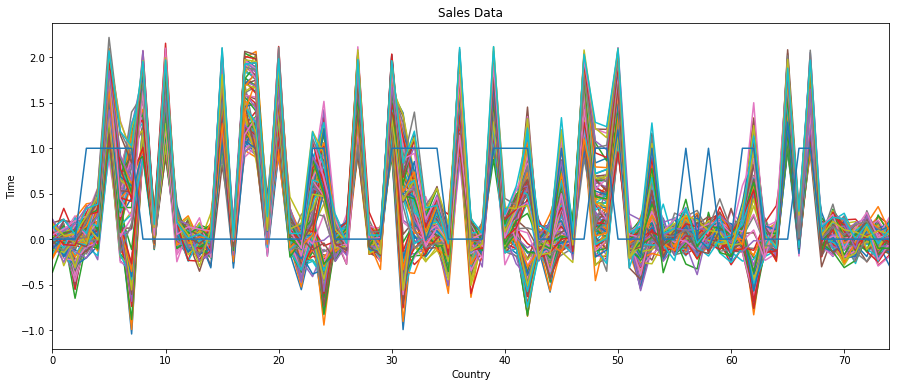

In [4]:
def plot_dataset(dataset):
    ax = dataset.loc[:, dataset.columns != 'Id'].plot(figsize = (15,6), title="Sales Data", legend = False)
    ax.set(xlabel="Country", ylabel="Time")
    plt.show()

plot_dataset(train_df)

### Test Data

Similarly, we will now load the `test.csv` dataset and take a look at the data contained in it.

In [5]:
test_df = pd.read_csv('./data/test.csv')
print(f'Shape: {test_df.shape}')
test_df.head()

Shape: (120, 101)


,Id,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,0,1.050702,1.004361,0.880657,0.959512,1.014129,0.890916,0.986703,1.135940,1.223539,...,1.826883,1.797263,1.872348,1.926992,1.843073,1.958611,1.800846,1.867793,2.056990,2.060379
1,1,-0.042360,-0.134542,-0.093373,0.076402,-0.122659,-0.149690,-0.050888,0.087327,-0.003546,...,0.233283,0.265816,0.218283,0.134600,0.273861,0.056165,0.103871,0.099539,0.305985,0.294278
2,2,0.035063,0.050938,0.067512,0.117029,0.049060,-0.014029,0.079372,0.204120,0.002883,...,-0.005722,0.195326,0.169835,0.255006,0.211215,0.116720,0.162032,0.116356,0.305580,0.202131
3,3,-0.111408,-0.063093,-0.094206,-0.054800,-0.021415,0.083715,-0.032116,-0.158563,0.114007,...,0.074536,0.009352,-0.016270,-0.087119,0.007215,0.073824,-0.114334,0.008747,0.023304,-0.071806
4,4,0.977574,0.989015,1.243740,1.111227,1.288457,1.000790,1.052081,0.937450,0.999783,...,1.907418,1.892012,1.780125,1.899383,1.939521,1.896775,2.038367,2.071734,1.982058,2.023052


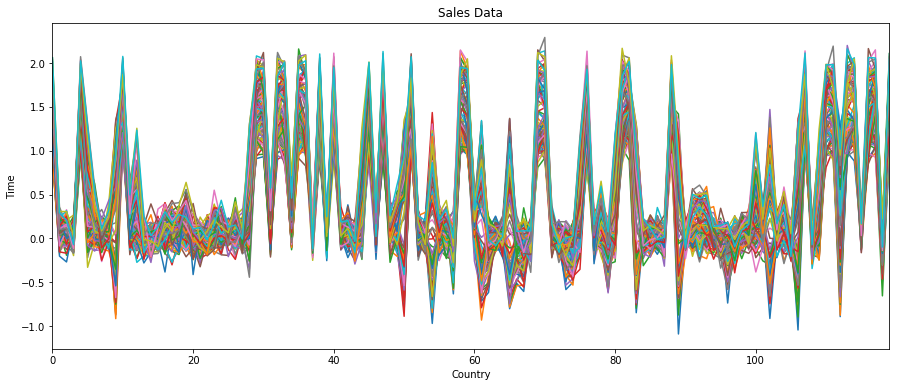

In [6]:
plot_dataset(test_df)

# PyMC3

Here we will utilize PyMC3 to detect and remove the seasonal component of each countries sales data if one is present.

### Applying PyMC3 model to train dataset

To start we will focus on one country (row) from the `train` dataset. We can now plot sales data for country which can give us a better understanding of a particular countries sales projection.

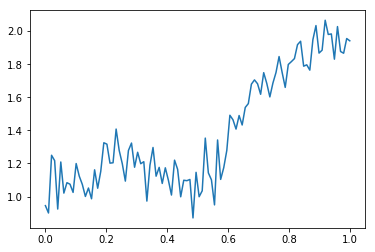

In [7]:
def get_single_row(df, row):
    '''
    Pull a singe row from the data (df).
    X is linearly space from 0 to 1.
    '''
    X = np.linspace(0, 1, 100)
    Y = df.iloc[row, 1:101].values
    X = X[:, None]
    Y = Y[:, None]
    return X, Y

X, Y = get_single_row(train_df, 18)
plt.plot(X,Y)
plt.show()

In [8]:
with pm.Model() as model:
    #  periodic component x 
    η_true  = pm.Normal("η_true", mu=0.1, sigma=3)
    ℓ_true  = pm.Normal("ℓ_true", mu=0.1, sigma=3)

    cov_seasonal = η_true**2 * pm.gp.cov.ExpQuad(1, ℓ_true) # Maybe change this to 100 since its 100 dimentions
    gp1 = pm.gp.Marginal(cov_func=cov_seasonal)

    #  linear component x 
    cov_linear = η_true**2 * pm.gp.cov.Matern32(1, ℓ_true) # Maybe change this to 100 since its 100 dimentions
    gp2 = pm.gp.Marginal(cov_func=cov_linear)

    # gp represents f1 + f2.
    gp = gp1 + gp2

    # noise model
    sigma = pm.HalfCauchy("sigma", beta=5, testval=0.1)
    f = gp.marginal_likelihood("f", X, Y[:,0], noise=sigma)

    # this line calls an optimizer to optimize the marginal likelihood
    mp = pm.find_MAP(include_transformed=True)

logp = 66.555, ||grad|| = 0.03297: 100%|██████████| 18/18 [00:00<00:00, 235.10it/s]  


In [9]:
#optimized parameters
sorted([name+":"+str(mp[name]) for name in mp.keys() if not name.endswith("_")])

['sigma:0.09646366589418474',
 'η_true:0.9217250135046413',
 'ℓ_true:0.7831299949373917']

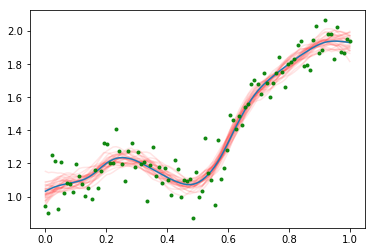

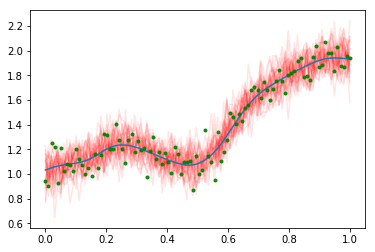

In [10]:
# 200 new values from x=0 to x=3
n_new = 100
X_new = np.linspace(0, 1, n_new)[:,None]

#periodic term
f1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma})
y1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma}, pred_noise=True)
#linear term
f2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma})
y2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma}, pred_noise=True)
#sum of periodic and linear term
y_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma}, pred_noise=True)
f_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma})

#we sample 10 regression lines from the posterior
sample_f = multivariate_normal(f_pred[0],f_pred[1]).rvs(30)

plt.plot(X_new[:,0],sample_f.T,color='red',alpha=0.1)# regression lines
plt.plot(X_new[:,0],f_pred[0])# this is the average line
plt.plot(X, Y, 'og', ms=3, alpha=0.9, label="Observed data", Zorder=1000);
plt.show()

#we sample 10 regression lines from the posterior
sample_y = multivariate_normal(y_pred[0],y_pred[1]).rvs(30)

plt.plot(X_new[:,0],sample_y.T,color='red',alpha=0.1)# regression lines
plt.plot(X_new[:,0],f_pred[0])# this is the average line
plt.plot(X, Y, 'og', ms=3, alpha=0.9, label="Observed data", Zorder=1000);
plt.show()

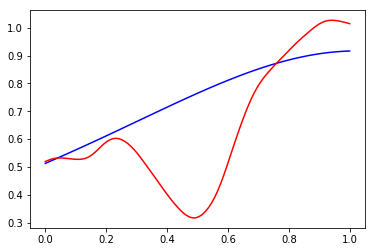

In [11]:
#we can recover the single components
plt.plot(X_new[:,0],f1_pred[0], color="blue")
plt.plot(X_new[:,0],f2_pred[0], color="red")
plt.show()

In [12]:
f2_pred[0]

array([0.51946469, 0.52392334, 0.52786946, 0.5305984 , 0.53195748,
       0.5322654 , 0.5316632 , 0.53053916, 0.52923668, 0.52807594,
       0.52732341, 0.52715397, 0.52802208, 0.53052087, 0.53512099,
       0.54194278, 0.55076178, 0.56093719, 0.57171043, 0.58202861,
       0.59079901, 0.59735818, 0.60143145, 0.60276904, 0.6011748 ,
       0.59694632, 0.59059285, 0.58245608, 0.57249989, 0.56078336,
       0.54762873, 0.53334316, 0.51835042, 0.50310973, 0.48798024,
       0.47277085, 0.45728032, 0.44165866, 0.42608674, 0.41077977,
       0.39586617, 0.38156849, 0.36804266, 0.35526444, 0.3435376 ,
       0.33340554, 0.32525785, 0.31950829, 0.31667294, 0.31723384,
       0.32119129, 0.32853167, 0.33900222, 0.35227466, 0.36862937,
       0.38849874, 0.41202221, 0.43877262, 0.46844223, 0.50038215,
       0.53356403, 0.56690758, 0.59975633, 0.63175629, 0.66258815,
       0.6919647 , 0.71946061, 0.7446406 , 0.76714602, 0.78692838,
       0.80427573, 0.81962756, 0.83338933, 0.84612299, 0.85833

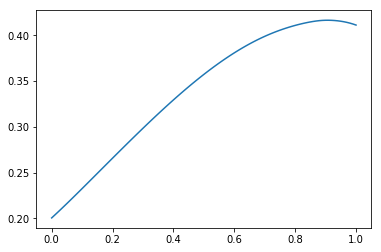

In [13]:
plt.plot(X_new[:,0],f2_pred[1][88])
plt.show()

### Applying PyMC3 model to test dataset

Defining `run_model_pymc` method that we will call in a loop for each row in the dataset.

In [14]:
def run_model_pymc(x_in, y_in, plot=False):
    with pm.Model() as model:
        #  periodic component x 
        η_true  = pm.Normal("η_true", mu=0.1, sigma=3)
        ℓ_true  = pm.Normal("ℓ_true", mu=0.1, sigma=3)

        cov_seasonal = η_true**2 * pm.gp.cov.ExpQuad(1, ℓ_true) # Maybe change this to 100 since its 100 dimentions
        gp1 = pm.gp.Marginal(cov_func=cov_seasonal)

        #  linear component x 
        cov_linear = η_true**2 * pm.gp.cov.Matern32(1, ℓ_true) # Maybe change this to 100 since its 100 dimentions
        gp2 = pm.gp.Marginal(cov_func=cov_linear)

        # gp represents f1 + f2.
        gp = gp1 + gp2

        # noise model
        sigma = pm.HalfCauchy("sigma", beta=5, testval=0.1)
        f = gp.marginal_likelihood("f", x_in, y_in[:,0], noise=sigma)

        # this line calls an optimizer to optimize the marginal likelihood
        mp = pm.find_MAP(include_transformed=True)

    # 200 new values from x=0 to x=3
    n_new = 100
    X_new = np.linspace(0, 1, n_new)[:,None]

    #periodic term
    f1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma})
    y1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma}, pred_noise=True)
    #linear term
    f2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma})
    y2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma}, pred_noise=True)
    #sum of periodic and linear term
    y_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma}, pred_noise=True)
    f_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma})
    
    posterior_probability_deriviative_is_positive = len(np.where(np.gradient(f2_pred[0],X_new[:,0])>0)[0])/len(f2_pred[0])
    
    print("Probability Sales Increasing is: ", posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.8:
        return 1
    else:
        return 0

Here we define the x space as linearly distributed between 0 and 1 for 100 points. We then loop over each row in our test dataset and run the model defined above on the data.

In [15]:
def make_decision(dataset, run_model, num_rows=0):
    '''
        Method to execute decision loop.
        dataset: data to iterate
        run_model: method that runs model on x and y data
        num_rows: this can be used to only target a specific number of rows. If 0 then the full dataset is used.
    '''
    num_rows = dataset.shape[0] if num_rows == 0 else num_rows
    x = np.linspace(0,1,100)[:,None]
    Decision = pd.DataFrame(columns=['Id','Category'])
    
    for r in range(num_rows):
        id_row = dataset.iloc[r, 0]
        y = dataset.iloc[r, 1:101].values[:,None]
        decision = run_model(x, y)
        Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True)
        print(f'{r + 1}/{num_rows} rows complete')
        
    return Decision

In [16]:
Decision = make_decision(test_df, run_model_pymc)
Decision.to_csv('submission_pymc3.csv')
print(Decision)

logp = 70.088, ||grad|| = 0.016035: 100%|██████████| 25/25 [00:00<00:00, 267.24it/s]  


Probability Sales Increasing is:  1.0
1/120 rows complete


logp = 79.029, ||grad|| = 0.27356: 100%|██████████| 15/15 [00:00<00:00, 218.78it/s]  


Probability Sales Increasing is:  0.75
2/120 rows complete


logp = 81.088, ||grad|| = 12.25: 100%|██████████| 21/21 [00:00<00:00, 265.55it/s]  


Probability Sales Increasing is:  0.6
3/120 rows complete


logp = 83.11, ||grad|| = 4.6177: 100%|██████████| 29/29 [00:00<00:00, 272.81it/s]   


Probability Sales Increasing is:  0.51
4/120 rows complete


logp = 64.607, ||grad|| = 0.40017: 100%|██████████| 20/20 [00:00<00:00, 209.38it/s]  


Probability Sales Increasing is:  0.75
5/120 rows complete


logp = 66.709, ||grad|| = 11.903: 100%|██████████| 19/19 [00:00<00:00, 276.27it/s]  


Probability Sales Increasing is:  0.57
6/120 rows complete


logp = 72.839, ||grad|| = 0.48624: 100%|██████████| 17/17 [00:00<00:00, 265.81it/s]  


Probability Sales Increasing is:  0.8
7/120 rows complete


logp = 81.506, ||grad|| = 0.19752: 100%|██████████| 26/26 [00:00<00:00, 289.49it/s]  


Probability Sales Increasing is:  0.98
8/120 rows complete


logp = 75.192, ||grad|| = 0.00093609: 100%|██████████| 13/13 [00:00<00:00, 67.47it/s]  


Probability Sales Increasing is:  0.47
9/120 rows complete


logp = 54.919, ||grad|| = 6.0602: 100%|██████████| 28/28 [00:00<00:00, 288.55it/s]  


Probability Sales Increasing is:  0.62
10/120 rows complete


logp = 67.529, ||grad|| = 0.55685: 100%|██████████| 21/21 [00:00<00:00, 275.52it/s]  


Probability Sales Increasing is:  0.82
11/120 rows complete


logp = 70.225, ||grad|| = 0.12948: 100%|██████████| 18/18 [00:00<00:00, 273.17it/s]  


Probability Sales Increasing is:  1.0
12/120 rows complete


logp = 60.997, ||grad|| = 14.08: 100%|██████████| 20/20 [00:00<00:00, 281.97it/s]  


Probability Sales Increasing is:  0.53
13/120 rows complete


logp = 78.106, ||grad|| = 5.5721: 100%|██████████| 16/16 [00:00<00:00, 251.37it/s]  


Probability Sales Increasing is:  0.43
14/120 rows complete


logp = 66.433, ||grad|| = 0.0013202: 100%|██████████| 22/22 [00:00<00:00, 284.42it/s]  


Probability Sales Increasing is:  0.46
15/120 rows complete


logp = 83.522, ||grad|| = 1.3617: 100%|██████████| 29/29 [00:00<00:00, 290.75it/s]  


Probability Sales Increasing is:  0.95
16/120 rows complete


logp = 57.858, ||grad|| = 0.84049: 100%|██████████| 19/19 [00:00<00:00, 286.88it/s]  


Probability Sales Increasing is:  0.77
17/120 rows complete


logp = 68.784, ||grad|| = 0.0049116: 100%|██████████| 13/13 [00:00<00:00, 245.50it/s]  


Probability Sales Increasing is:  0.57
18/120 rows complete


logp = 73.61, ||grad|| = 0.20097: 100%|██████████| 14/14 [00:00<00:00, 261.54it/s]  


Probability Sales Increasing is:  0.52
19/120 rows complete


logp = 71.665, ||grad|| = 0.044518: 100%|██████████| 19/19 [00:00<00:00, 270.03it/s]  


Probability Sales Increasing is:  1.0
20/120 rows complete


logp = 71.057, ||grad|| = 5.9456e-05: 100%|██████████| 22/22 [00:00<00:00, 199.04it/s]  


Probability Sales Increasing is:  0.62
21/120 rows complete


logp = 67.511, ||grad|| = 30.582: 100%|██████████| 27/27 [00:00<00:00, 244.85it/s]  


Probability Sales Increasing is:  0.49
22/120 rows complete


logp = 77.291, ||grad|| = 26.935: 100%|██████████| 21/21 [00:00<00:00, 269.05it/s]  


Probability Sales Increasing is:  0.5
23/120 rows complete


logp = 61.696, ||grad|| = 0.00076236: 100%|██████████| 13/13 [00:00<00:00, 253.82it/s]  


Probability Sales Increasing is:  0.53
24/120 rows complete


logp = 66.086, ||grad|| = 0.007008: 100%|██████████| 13/13 [00:00<00:00, 255.76it/s]  


Probability Sales Increasing is:  0.49
25/120 rows complete


logp = 93.475, ||grad|| = 0.16638: 100%|██████████| 26/26 [00:00<00:00, 282.00it/s]  


Probability Sales Increasing is:  0.27
26/120 rows complete


logp = 64.687, ||grad|| = 0.012814: 100%|██████████| 13/13 [00:00<00:00, 261.57it/s]  


Probability Sales Increasing is:  0.52
27/120 rows complete


logp = 75.343, ||grad|| = 0.00044095: 100%|██████████| 22/22 [00:00<00:00, 282.16it/s]  


Probability Sales Increasing is:  0.88
28/120 rows complete


logp = 64.599, ||grad|| = 10.081: 100%|██████████| 20/20 [00:00<00:00, 273.76it/s]  


Probability Sales Increasing is:  0.53
29/120 rows complete


logp = 61.776, ||grad|| = 0.0058629: 100%|██████████| 24/24 [00:00<00:00, 287.17it/s]  


Probability Sales Increasing is:  1.0
30/120 rows complete


logp = 76.66, ||grad|| = 0.11049: 100%|██████████| 26/26 [00:00<00:00, 282.34it/s]  


Probability Sales Increasing is:  1.0
31/120 rows complete


logp = 73.407, ||grad|| = 0.096603: 100%|██████████| 18/18 [00:00<00:00, 266.71it/s]  


Probability Sales Increasing is:  0.91
32/120 rows complete


logp = 71.835, ||grad|| = 0.29674: 100%|██████████| 26/26 [00:00<00:00, 293.59it/s]  


Probability Sales Increasing is:  1.0
33/120 rows complete


logp = 61.755, ||grad|| = 0.016704: 100%|██████████| 26/26 [00:00<00:00, 272.18it/s]  


Probability Sales Increasing is:  1.0
34/120 rows complete


logp = 66.365, ||grad|| = 0.29754: 100%|██████████| 19/19 [00:00<00:00, 273.98it/s]  


Probability Sales Increasing is:  0.76
35/120 rows complete


logp = 58.664, ||grad|| = 0.019916: 100%|██████████| 25/25 [00:00<00:00, 277.26it/s]  


Probability Sales Increasing is:  1.0
36/120 rows complete


logp = 60.274, ||grad|| = 0.65628: 100%|██████████| 21/21 [00:00<00:00, 284.02it/s]  


Probability Sales Increasing is:  0.72
37/120 rows complete


logp = 76.007, ||grad|| = 0.0031595: 100%|██████████| 13/13 [00:00<00:00, 248.15it/s]  


Probability Sales Increasing is:  0.47
38/120 rows complete


logp = 70.802, ||grad|| = 0.44748: 100%|██████████| 19/19 [00:00<00:00, 274.95it/s]  


Probability Sales Increasing is:  0.7
39/120 rows complete


logp = 80.273, ||grad|| = 5.271: 100%|██████████| 18/18 [00:00<00:00, 270.66it/s]  


Probability Sales Increasing is:  0.65
40/120 rows complete


logp = 76.215, ||grad|| = 0.062981: 100%|██████████| 26/26 [00:00<00:00, 286.47it/s]  


Probability Sales Increasing is:  1.0
41/120 rows complete


logp = 80.982, ||grad|| = 0.28967: 100%|██████████| 26/26 [00:00<00:00, 286.35it/s]  


Probability Sales Increasing is:  0.78
42/120 rows complete


logp = 82.092, ||grad|| = 0.072551: 100%|██████████| 14/14 [00:00<00:00, 209.02it/s]  


Probability Sales Increasing is:  0.68
43/120 rows complete


logp = 79.489, ||grad|| = 0.016691: 100%|██████████| 13/13 [00:00<00:00, 247.69it/s]  


Probability Sales Increasing is:  0.58
44/120 rows complete


logp = 49.984, ||grad|| = 12.861: 100%|██████████| 21/21 [00:00<00:00, 220.10it/s]  


Probability Sales Increasing is:  0.5
45/120 rows complete


logp = 71.447, ||grad|| = 0.40535: 100%|██████████| 20/20 [00:00<00:00, 288.83it/s]  


Probability Sales Increasing is:  0.7
46/120 rows complete


logp = 65.273, ||grad|| = 0.0037152: 100%|██████████| 13/13 [00:00<00:00, 217.56it/s]  


Probability Sales Increasing is:  0.55
47/120 rows complete


logp = 77.895, ||grad|| = 1.7172: 100%|██████████| 21/21 [00:00<00:00, 170.59it/s]  


Probability Sales Increasing is:  0.78
48/120 rows complete


logp = 71.828, ||grad|| = 3.1284: 100%|██████████| 20/20 [00:00<00:00, 273.10it/s]  


Probability Sales Increasing is:  0.68
49/120 rows complete


logp = 67.24, ||grad|| = 1.0663: 100%|██████████| 19/19 [00:00<00:00, 210.14it/s]  


Probability Sales Increasing is:  0.84
50/120 rows complete


logp = 57.782, ||grad|| = 4.6381: 100%|██████████| 28/28 [00:00<00:00, 262.00it/s]  


Probability Sales Increasing is:  0.64
51/120 rows complete


logp = 60.677, ||grad|| = 0.0091052: 100%|██████████| 24/24 [00:00<00:00, 279.35it/s]  


Probability Sales Increasing is:  0.79
52/120 rows complete


logp = 72.821, ||grad|| = 0.089286: 100%|██████████| 15/15 [00:00<00:00, 222.25it/s]  


Probability Sales Increasing is:  0.76
53/120 rows complete


logp = 90.833, ||grad|| = 0.0009267: 100%|██████████| 22/22 [00:00<00:00, 236.86it/s]  


Probability Sales Increasing is:  1.0
54/120 rows complete


logp = 43.798, ||grad|| = 0.081702: 100%|██████████| 25/25 [00:00<00:00, 222.50it/s]  


Probability Sales Increasing is:  0.58
55/120 rows complete


logp = 86.218, ||grad|| = 0.065569: 100%|██████████| 14/14 [00:00<00:00, 153.61it/s]  


Probability Sales Increasing is:  0.47
56/120 rows complete


logp = 63.837, ||grad|| = 0.012047: 100%|██████████| 13/13 [00:00<00:00, 238.41it/s]  


Probability Sales Increasing is:  0.59
57/120 rows complete


logp = 66.903, ||grad|| = 0.25004: 100%|██████████| 16/16 [00:00<00:00, 280.11it/s]  


Probability Sales Increasing is:  0.47
58/120 rows complete


logp = 69.196, ||grad|| = 0.80881: 100%|██████████| 21/21 [00:00<00:00, 286.13it/s]  


Probability Sales Increasing is:  0.7
59/120 rows complete


logp = 65.894, ||grad|| = 0.27202: 100%|██████████| 20/20 [00:00<00:00, 314.21it/s]  


Probability Sales Increasing is:  0.72
60/120 rows complete


logp = 72.459, ||grad|| = 0.56107: 100%|██████████| 19/19 [00:00<00:00, 283.91it/s]  


Probability Sales Increasing is:  1.0
61/120 rows complete


logp = 51.066, ||grad|| = 0.0044444: 100%|██████████| 23/23 [00:00<00:00, 232.59it/s]  


Probability Sales Increasing is:  0.57
62/120 rows complete


logp = 67.254, ||grad|| = 0.23029: 100%|██████████| 16/16 [00:00<00:00, 259.27it/s]  


Probability Sales Increasing is:  0.54
63/120 rows complete


logp = 88, ||grad|| = 10.549: 100%|██████████| 31/31 [00:00<00:00, 223.47it/s]      


Probability Sales Increasing is:  0.97
64/120 rows complete


logp = 82.921, ||grad|| = 0.10402: 100%|██████████| 24/24 [00:00<00:00, 281.37it/s]  


Probability Sales Increasing is:  0.94
65/120 rows complete


logp = 57.162, ||grad|| = 0.021661: 100%|██████████| 24/24 [00:00<00:00, 271.02it/s]  


Probability Sales Increasing is:  0.57
66/120 rows complete


logp = 71.958, ||grad|| = 0.15978: 100%|██████████| 15/15 [00:00<00:00, 249.72it/s]  


Probability Sales Increasing is:  0.69
67/120 rows complete


logp = 57.116, ||grad|| = 1.9725: 100%|██████████| 18/18 [00:00<00:00, 234.12it/s]  


Probability Sales Increasing is:  0.61
68/120 rows complete


logp = 77.571, ||grad|| = 0.12383: 100%|██████████| 24/24 [00:00<00:00, 258.69it/s]  


Probability Sales Increasing is:  0.46
69/120 rows complete


logp = 61.966, ||grad|| = 0.62011: 100%|██████████| 20/20 [00:00<00:00, 267.46it/s]  


Probability Sales Increasing is:  0.69
70/120 rows complete


logp = 61.73, ||grad|| = 0.50891: 100%|██████████| 21/21 [00:00<00:00, 266.63it/s]  


Probability Sales Increasing is:  0.72
71/120 rows complete


logp = 73.5, ||grad|| = 0.091234: 100%|██████████| 27/27 [00:00<00:00, 245.94it/s]  


Probability Sales Increasing is:  0.87
72/120 rows complete


logp = 77.879, ||grad|| = 2.584: 100%|██████████| 30/30 [00:00<00:00, 268.56it/s]   


Probability Sales Increasing is:  0.31
73/120 rows complete


logp = 72.483, ||grad|| = 0.42485: 100%|██████████| 15/15 [00:00<00:00, 167.75it/s]  


Probability Sales Increasing is:  0.6
74/120 rows complete


logp = 77.718, ||grad|| = 3.1721: 100%|██████████| 21/21 [00:00<00:00, 274.37it/s]  


Probability Sales Increasing is:  0.56
75/120 rows complete


logp = 55.194, ||grad|| = 7.1715: 100%|██████████| 19/19 [00:00<00:00, 266.83it/s]  


Probability Sales Increasing is:  0.6
76/120 rows complete


logp = 59.172, ||grad|| = 0.11636: 100%|██████████| 20/20 [00:00<00:00, 257.57it/s]  


Probability Sales Increasing is:  0.7
77/120 rows complete


logp = 77.381, ||grad|| = 21.464: 100%|██████████| 19/19 [00:00<00:00, 264.69it/s]  


Probability Sales Increasing is:  0.52
78/120 rows complete


logp = 82.305, ||grad|| = 1.2624: 100%|██████████| 20/20 [00:00<00:00, 249.00it/s]  


Probability Sales Increasing is:  0.76
79/120 rows complete


logp = 65.947, ||grad|| = 0.12327: 100%|██████████| 15/15 [00:00<00:00, 262.84it/s]  


Probability Sales Increasing is:  0.61
80/120 rows complete


logp = 54.116, ||grad|| = 16.154: 100%|██████████| 20/20 [00:00<00:00, 272.29it/s]  


Probability Sales Increasing is:  0.51
81/120 rows complete


logp = 63.845, ||grad|| = 0.00088728: 100%|██████████| 22/22 [00:00<00:00, 285.86it/s]  


Probability Sales Increasing is:  0.8
82/120 rows complete


logp = 73.29, ||grad|| = 0.12412: 100%|██████████| 25/25 [00:00<00:00, 293.92it/s]  


Probability Sales Increasing is:  1.0
83/120 rows complete


logp = 43.673, ||grad|| = 0.95655: 100%|██████████| 26/26 [00:00<00:00, 327.84it/s]  


Probability Sales Increasing is:  0.55
84/120 rows complete


logp = 82.668, ||grad|| = 20.685: 100%|██████████| 17/17 [00:00<00:00, 244.96it/s]  


Probability Sales Increasing is:  0.52
85/120 rows complete


logp = 76.087, ||grad|| = 19.73: 100%|██████████| 18/18 [00:00<00:00, 262.90it/s]  


Probability Sales Increasing is:  0.44
86/120 rows complete


logp = 83.789, ||grad|| = 0.68673: 100%|██████████| 27/27 [00:00<00:00, 283.93it/s]  


Probability Sales Increasing is:  0.79
87/120 rows complete


logp = 75.834, ||grad|| = 0.00056672: 100%|██████████| 22/22 [00:00<00:00, 243.46it/s]  


Probability Sales Increasing is:  0.5
88/120 rows complete


logp = 61.697, ||grad|| = 0.00020881: 100%|██████████| 22/22 [00:00<00:00, 251.62it/s]  


Probability Sales Increasing is:  0.78
89/120 rows complete


logp = 42.189, ||grad|| = 4.2626: 100%|██████████| 27/27 [00:00<00:00, 279.96it/s]  


Probability Sales Increasing is:  0.53
90/120 rows complete


logp = 89.097, ||grad|| = 0.01712: 100%|██████████| 22/22 [00:00<00:00, 279.22it/s]  


Probability Sales Increasing is:  0.31
91/120 rows complete


logp = 76.396, ||grad|| = 0.060103: 100%|██████████| 19/19 [00:00<00:00, 253.20it/s]  


Probability Sales Increasing is:  1.0
92/120 rows complete


logp = 70.201, ||grad|| = 1.0297: 100%|██████████| 25/25 [00:00<00:00, 262.36it/s]  


Probability Sales Increasing is:  0.72
93/120 rows complete


logp = 91.505, ||grad|| = 0.20968: 100%|██████████| 19/19 [00:00<00:00, 273.77it/s]  


Probability Sales Increasing is:  0.81
94/120 rows complete


logp = 73.457, ||grad|| = 0.10563: 100%|██████████| 25/25 [00:00<00:00, 273.94it/s]  


Probability Sales Increasing is:  0.84
95/120 rows complete


logp = 70.798, ||grad|| = 2.5678: 100%|██████████| 18/18 [00:00<00:00, 270.29it/s]  


Probability Sales Increasing is:  0.54
96/120 rows complete


logp = 76.361, ||grad|| = 0.041442: 100%|██████████| 16/16 [00:00<00:00, 235.63it/s]  


Probability Sales Increasing is:  0.59
97/120 rows complete


logp = 66.162, ||grad|| = 1.1911: 100%|██████████| 26/26 [00:00<00:00, 281.83it/s]  


Probability Sales Increasing is:  0.6
98/120 rows complete


logp = 84.094, ||grad|| = 2.2893: 100%|██████████| 18/18 [00:00<00:00, 254.17it/s]  


Probability Sales Increasing is:  0.79
99/120 rows complete


logp = 77.635, ||grad|| = 0.0006582: 100%|██████████| 24/24 [00:00<00:00, 267.85it/s]  


Probability Sales Increasing is:  1.0
100/120 rows complete


logp = 54.595, ||grad|| = 19.709: 100%|██████████| 21/21 [00:00<00:00, 277.13it/s]  


Probability Sales Increasing is:  0.54
101/120 rows complete


logp = 66.155, ||grad|| = 0.013395: 100%|██████████| 13/13 [00:00<00:00, 228.86it/s]  


Probability Sales Increasing is:  0.47
102/120 rows complete


logp = 41.19, ||grad|| = 2.8234: 100%|██████████| 27/27 [00:00<00:00, 236.55it/s]   


Probability Sales Increasing is:  0.57
103/120 rows complete


logp = 71.588, ||grad|| = 2.4096: 100%|██████████| 21/21 [00:00<00:00, 225.82it/s]  


Probability Sales Increasing is:  0.72
104/120 rows complete


logp = 67.351, ||grad|| = 0.62094: 100%|██████████| 19/19 [00:00<00:00, 264.71it/s]  


Probability Sales Increasing is:  1.0
105/120 rows complete


logp = 79.647, ||grad|| = 5.6958: 100%|██████████| 19/19 [00:00<00:00, 264.05it/s]  


Probability Sales Increasing is:  0.63
106/120 rows complete


logp = 58.037, ||grad|| = 0.16131: 100%|██████████| 21/21 [00:00<00:00, 285.43it/s]  


Probability Sales Increasing is:  0.54
107/120 rows complete


logp = 60.002, ||grad|| = 1.2792: 100%|██████████| 20/20 [00:00<00:00, 243.33it/s]  


Probability Sales Increasing is:  0.77
108/120 rows complete


logp = 74.502, ||grad|| = 0.46038: 100%|██████████| 27/27 [00:00<00:00, 182.90it/s]  


Probability Sales Increasing is:  0.63
109/120 rows complete


logp = 68.563, ||grad|| = 5.6549e-05: 100%|██████████| 22/22 [00:00<00:00, 312.07it/s]  


Probability Sales Increasing is:  0.52
110/120 rows complete


logp = 82.167, ||grad|| = 0.024795: 100%|██████████| 25/25 [00:00<00:00, 206.49it/s]  


Probability Sales Increasing is:  1.0
111/120 rows complete


logp = 66.822, ||grad|| = 0.48575: 100%|██████████| 24/24 [00:00<00:00, 254.81it/s]  


Probability Sales Increasing is:  1.0
112/120 rows complete


logp = 53.212, ||grad|| = 0.049819: 100%|██████████| 25/25 [00:00<00:00, 277.67it/s]  


Probability Sales Increasing is:  0.57
113/120 rows complete


logp = 51.873, ||grad|| = 0.058572: 100%|██████████| 19/19 [00:00<00:00, 220.09it/s]  


Probability Sales Increasing is:  0.66
114/120 rows complete


logp = 72.595, ||grad|| = 0.0028595: 100%|██████████| 23/23 [00:00<00:00, 204.24it/s]  


Probability Sales Increasing is:  0.81
115/120 rows complete


logp = 80.444, ||grad|| = 3.6374: 100%|██████████| 29/29 [00:00<00:00, 285.27it/s]  


Probability Sales Increasing is:  1.0
116/120 rows complete


logp = 74.49, ||grad|| = 0.53124: 100%|██████████| 21/21 [00:00<00:00, 272.75it/s]  


Probability Sales Increasing is:  0.68
117/120 rows complete


logp = 74.773, ||grad|| = 0.00090703: 100%|██████████| 23/23 [00:00<00:00, 260.78it/s]  


Probability Sales Increasing is:  1.0
118/120 rows complete


logp = 60.147, ||grad|| = 0.0051496: 100%|██████████| 13/13 [00:00<00:00, 234.63it/s]  


Probability Sales Increasing is:  0.55
119/120 rows complete


logp = 58.596, ||grad|| = 0.88226: 100%|██████████| 21/21 [00:00<00:00, 288.28it/s]  


Probability Sales Increasing is:  0.81
120/120 rows complete
      Id Category
0      0        1
1      1        0
2      2        0
3      3        0
4      4        0
5      5        0
6      6        0
7      7        1
8      8        0
9      9        0
10    10        1
11    11        1
12    12        0
13    13        0
14    14        0
15    15        1
16    16        0
17    17        0
18    18        0
19    19        1
20    20        0
21    21        0
22    22        0
23    23        0
24    24        0
25    25        0
26    26        0
27    27        1
28    28        0
29    29        1
..   ...      ...
90    90        0
91    91        1
92    92        0
93    93        1
94    94        1
95    95        0
96    96        0
97    97        0
98    98        0
99    99        1
100  100        0
101  101        0
102  102        0
103  103        0
104  104        1
105  105        0
106  106        0
107  107        0
108  108        0
109  109        0
110

## GPy

Here we move away from PyMC3 and use another PML package called GPy. We compare how both performed on the Sales data.

### Applying GPy model to train dataset

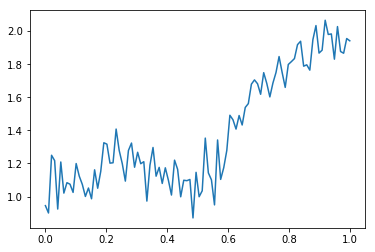

In [17]:
selected_row = 18

X,Y = get_single_row(train_df, selected_row)

plt.plot(X,Y)
plt.show()

X_test = X
X_test = X_test.reshape(-1,1)

Create GPy model to train on the row selected above.

Optimization restart 1/5, f = 8.265556722461234
Optimization restart 2/5, f = 6.332897960435687
Optimization restart 3/5, f = 6.332897960587893
Optimization restart 4/5, f = 8.265560331556607
Optimization restart 5/5, f = 8.265562404987605


GP_regression.,value,constraints,priors
mul.ExpQuad.variance,17.257547328487313,+ve,
mul.ExpQuad.lengthscale,0.5504964930323976,+ve,
mul.periodic_exponential.variance,17.545718215089764,+ve,
mul.periodic_exponential.lengthscale,1.2924510193158985,+ve,
mul.periodic_exponential.period,5.535022098879126,+ve,
mul.linear.variances,17.397286982725326,+ve,
Gaussian_noise.variance,0.033290590583665354,+ve,


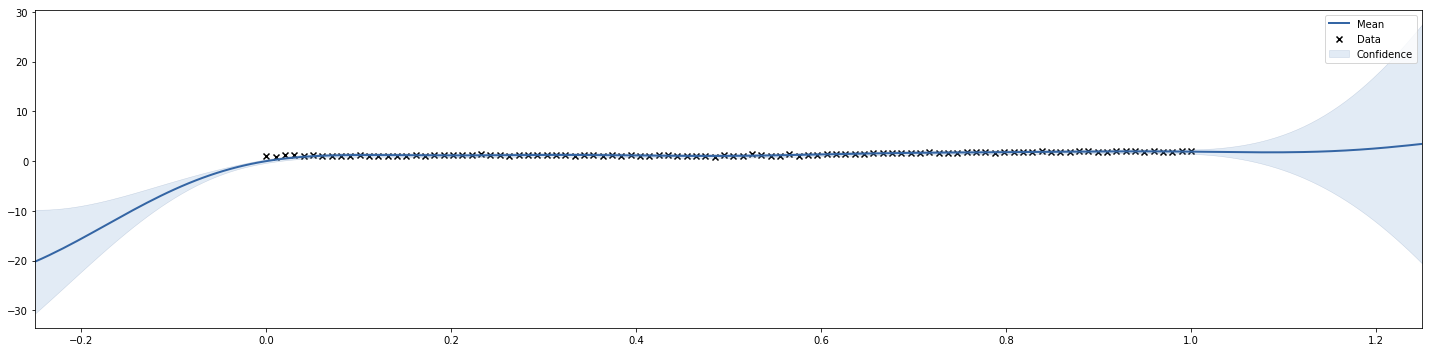

In [18]:
import GPy as GPy

#RBF
ker1 = GPy.kern.ExpQuad(1)
#Periodic
ker2 = GPy.kern.PeriodicExponential(1, period=6) 
#Polynomial of degree 6
ker3 = GPy.kern.Linear(1) 

kernel = ker1*ker2*ker3

# create a GP model
g_model = GPy.models.GPRegression(X,Y,kernel=kernel)

# it finds the optimal parameters of the RBF kernel by maxisiming the marginal likelihood 
g_model.optimize_restarts(5)# this maximise the marginal likelihood, with random restarts
#we  plot it
fig = g_model.plot(figsize=(20,5))
display(g_model)

In [19]:
f2_pred, sigm2_pred = g_model.predict(X_test, kern=kernel)

In [20]:
posterior_probability_deriviative_is_positive = len(np.where(np.gradient(f2_pred[:,0],X_test[:,0])>0)[0])/len(f2_pred[:,0])
    
print("Probability Sales Increasing is: ", posterior_probability_deriviative_is_positive)
if posterior_probability_deriviative_is_positive>0.8:
    print("1")
else:
    print("0")

Probability Sales Increasing is:  0.69
0


In [21]:
train_df['Category'][selected_row]

0

# Notes
* Test 1 - Used RBF & Matern32
 * Definitely don't use RBF as selected kernel
 * Removing linespace=100 improved the accuracy to 0.6 selecting Matern32
* Test 2 - Used RBF & Poly order = 3. Selected Poly
 * Worse - dropped to 0.5
* Test 3 - Used RBF & PeriodicExponential. Selected PeriodicExponential
 * Improved to 0.75
 * Increased to predict against 30 countries from 20 - Reduced to 73
 * Increased to predict against 50 countries from 30 - Reduced to 68
 * Increased optimize restarts from 5 to 10 - No change still 66
* Test 4 - RBF, PeriodicExponential, White
 * Had zero effect - probably because white looks like a zero based function
* Test 5 - ExpQuad, PeriodicExponential, Matern52. Selected ExpQuad
 * Typical 60% accuracy
* Test 6 - RBF, PeriodicExponential, Poly
 * Typical 60%
* Test 7 - ExpQuad, PeriodicMatern52, Linear, Poly
 * Thinking here was that a linear function may help identify the trend without the noise affecting it
 * Not sure exactly why I'm thinking this
 * didn't work, promising at smaller numbers of samples, got worse as I increased number of countries

In [22]:
def run_model_gpy(x_in, y_in):
    ker1 = GPy.kern.PeriodicExponential(1, variance=.6, lengthscale=.9)
    ker2 = GPy.kern.Linear(1, ARD=True)
    ker3 = GPy.kern.Matern32(1, variance=.1, lengthscale=.7, ARD=True, active_dims=0)
    
    kernel = ker1*ker2*ker3

    # create a GP model
    g_model = GPy.models.GPRegression(x_in,y_in,kernel=kernel)

    # it finds the optimal parameters of the RBF kernel by maxisiming the marginal likelihood 
    g_model.optimize_restarts(5)# this maximise the marginal
    
    X_test = x_in
    X_test = X_test.reshape(-1,1)
    
    f2_pred, sigm2_pred = g_model.predict(X_test, kern=ker3)
    
    posterior_probability_deriviative_is_positive = len(np.where(np.gradient(f2_pred[:,0],X_test[:,0])>0)[0])/len(f2_pred[:,0])
    is_increasing = posterior_probability_deriviative_is_positive > 0.8
    
    print(f'\nProbability Sales Increasing is: {posterior_probability_deriviative_is_positive}')
    print(f'Sales Increasing: {is_increasing}')
    plt.plot(x_in,y_in)
    plt.plot(x_in[:,0],f2_pred)
    plt.show()
    
    if is_increasing:
        return 1
    else:
        return 0

Optimization restart 1/5, f = -85.57310769176115
Optimization restart 2/5, f = -86.87679198977978
Optimization restart 3/5, f = -87.0899468335418
Optimization restart 4/5, f = -86.52457691692376
Optimization restart 5/5, f = -86.52455549122575

Probability Sales Increasing is: 0.42
Sales Increasing: False


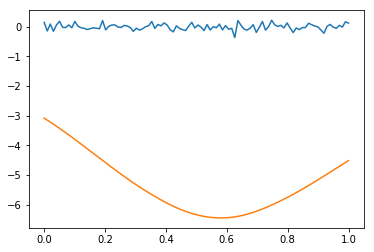

1/30 rows complete
Optimization restart 1/5, f = -84.3413962713377
Optimization restart 2/5, f = -83.57770422102763
Optimization restart 3/5, f = -83.5324600752302
Optimization restart 4/5, f = -83.51930591336426
Optimization restart 5/5, f = -83.51929999247716

Probability Sales Increasing is: 0.57
Sales Increasing: False


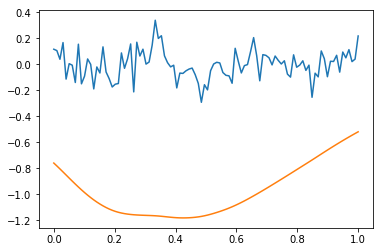

2/30 rows complete
Optimization restart 1/5, f = -33.188746998369915
Optimization restart 2/5, f = -25.822845257648964
Optimization restart 3/5, f = -11.534230674273616
Optimization restart 4/5, f = -32.087911673030185
Optimization restart 5/5, f = -32.08850916555752

Probability Sales Increasing is: 0.99
Sales Increasing: True


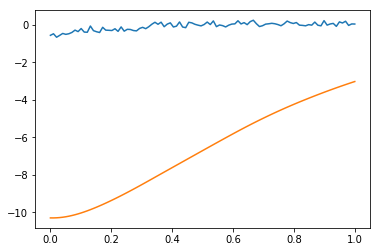

3/30 rows complete
Optimization restart 1/5, f = -80.05897809844032
Optimization restart 2/5, f = -43.15475037335681
Optimization restart 3/5, f = -80.7833568276842
Optimization restart 4/5, f = -80.78336349472269
Optimization restart 5/5, f = -79.28188081379466

Probability Sales Increasing is: 0.03
Sales Increasing: False


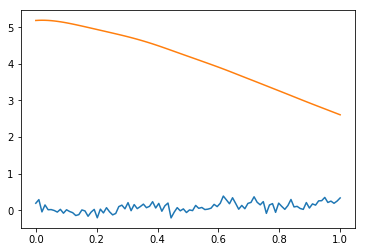

4/30 rows complete
Optimization restart 1/5, f = -90.16106803346182
Optimization restart 2/5, f = -90.16047250882463
Optimization restart 3/5, f = -87.17269354381895
Optimization restart 4/5, f = 0.18463602442675864
Optimization restart 5/5, f = -90.16100095960493

Probability Sales Increasing is: 0.85
Sales Increasing: True


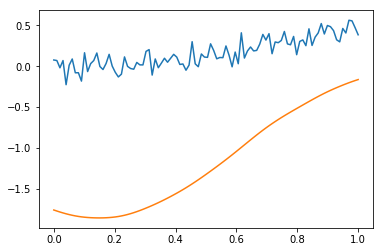

5/30 rows complete
Optimization restart 1/5, f = 7.008475355622487
Optimization restart 2/5, f = 7.19491042873338
Optimization restart 3/5, f = 7.008475361645949
Optimization restart 4/5, f = 113.26896328323984
Optimization restart 5/5, f = 7.151033662363773

Probability Sales Increasing is: 0.0
Sales Increasing: False


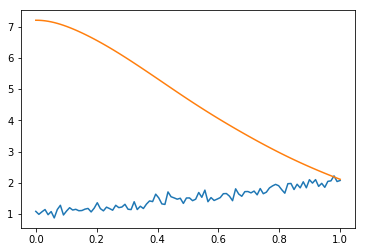

6/30 rows complete
Optimization restart 1/5, f = -57.448712213504216
Optimization restart 2/5, f = -60.11778131141991
Optimization restart 3/5, f = -59.65361056104826
Optimization restart 4/5, f = -59.65360114203948
Optimization restart 5/5, f = -60.09013368782394

Probability Sales Increasing is: 0.03
Sales Increasing: False


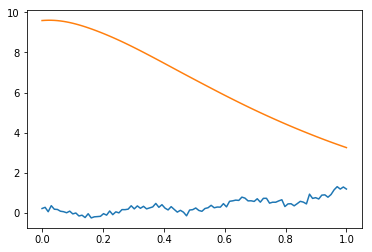

7/30 rows complete
Optimization restart 1/5, f = 4.911402078726589
Optimization restart 2/5, f = 3.667185772782247
Optimization restart 3/5, f = 4.9285228459782005
Optimization restart 4/5, f = 108.53791706674342
Optimization restart 5/5, f = 47.63154968012876

Probability Sales Increasing is: 1.0
Sales Increasing: True


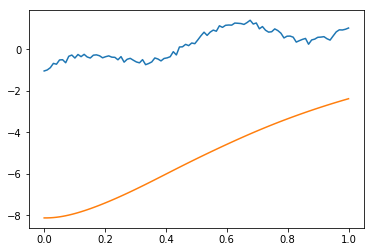

8/30 rows complete
Optimization restart 1/5, f = 0.24220187782572822
Optimization restart 2/5, f = -5.656541588598991
Optimization restart 3/5, f = 0.830156103262965
Optimization restart 4/5, f = 0.8301800690125631
Optimization restart 5/5, f = 95.64105039539886

Probability Sales Increasing is: 0.0
Sales Increasing: False


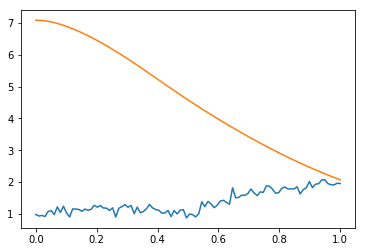

9/30 rows complete
Optimization restart 1/5, f = -106.01197448338326
Optimization restart 2/5, f = -105.96684939690147
Optimization restart 3/5, f = -105.8074786598802
Optimization restart 4/5, f = -105.89908509742281
Optimization restart 5/5, f = -106.09481573241858

Probability Sales Increasing is: 0.24
Sales Increasing: False


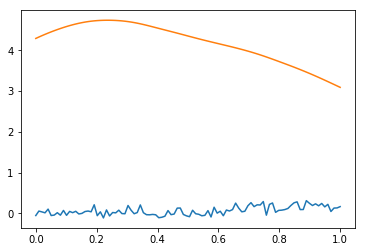

10/30 rows complete
Optimization restart 1/5, f = 6.372751592671548
Optimization restart 2/5, f = -6.37812884201584
Optimization restart 3/5, f = 53.85186085572771
Optimization restart 4/5, f = 180.74279065995051
Optimization restart 5/5, f = 6.372751592599094

Probability Sales Increasing is: 0.0
Sales Increasing: False


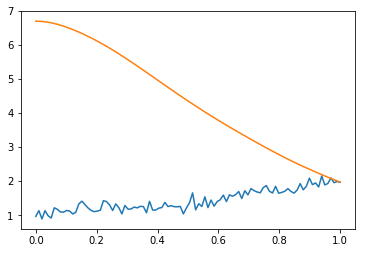

11/30 rows complete
Optimization restart 1/5, f = -88.48405139226247
Optimization restart 2/5, f = -86.4296420479597
Optimization restart 3/5, f = -86.86156506585857
Optimization restart 4/5, f = -88.52832208384194
Optimization restart 5/5, f = -86.66216834226191

Probability Sales Increasing is: 1.0
Sales Increasing: True


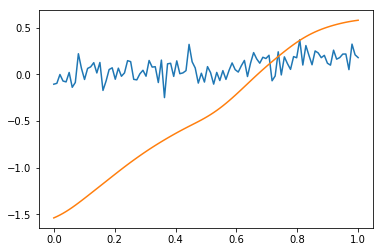

12/30 rows complete
Optimization restart 1/5, f = -88.40961368366538
Optimization restart 2/5, f = -88.61245680166002
Optimization restart 3/5, f = -88.60866008427885
Optimization restart 4/5, f = -88.53448234122743
Optimization restart 5/5, f = -89.86506586374506

Probability Sales Increasing is: 0.32
Sales Increasing: False


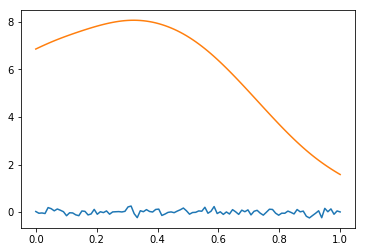

13/30 rows complete
Optimization restart 1/5, f = -84.49369020693617
Optimization restart 2/5, f = -82.91398287547014
Optimization restart 3/5, f = -84.35399112183501
Optimization restart 4/5, f = -83.68765822203711
Optimization restart 5/5, f = -80.80482130962625

Probability Sales Increasing is: 0.41
Sales Increasing: False


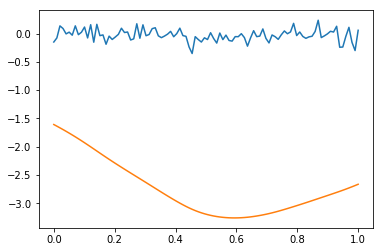

14/30 rows complete
Optimization restart 1/5, f = -82.80077840835739
Optimization restart 2/5, f = -82.78810601303769
Optimization restart 3/5, f = -82.9599575543296
Optimization restart 4/5, f = -82.61100065406936
Optimization restart 5/5, f = -82.95676867488115

Probability Sales Increasing is: 0.64
Sales Increasing: False


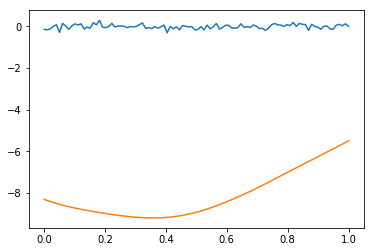

15/30 rows complete
Optimization restart 1/5, f = 10.046502274667489
Optimization restart 2/5, f = 142.22084448034113
Optimization restart 3/5, f = 9.986860849845804
Optimization restart 4/5, f = 6.511794096798319
Optimization restart 5/5, f = 9.9865433541542

Probability Sales Increasing is: 0.0
Sales Increasing: False


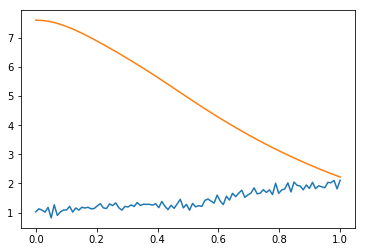

16/30 rows complete
Optimization restart 1/5, f = -73.25266552160724
Optimization restart 2/5, f = -74.2257965531717
Optimization restart 3/5, f = -74.15486204991893
Optimization restart 4/5, f = -73.25266541879414
Optimization restart 5/5, f = -74.92442612583463

Probability Sales Increasing is: 0.84
Sales Increasing: True


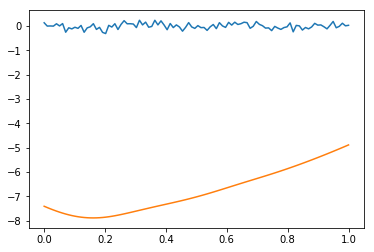

17/30 rows complete
Optimization restart 1/5, f = 9.772306446570099
Optimization restart 2/5, f = 141.01973130411884
Optimization restart 3/5, f = 9.135248869359124
Optimization restart 4/5, f = 9.135248869419769
Optimization restart 5/5, f = 53.61634667620632

Probability Sales Increasing is: 0.0
Sales Increasing: False


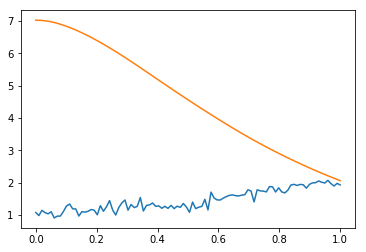

18/30 rows complete
Optimization restart 1/5, f = 8.265562331863485
Optimization restart 2/5, f = 7.297581646630093
Optimization restart 3/5, f = 8.386325697122288
Optimization restart 4/5, f = 8.4693822340641
Optimization restart 5/5, f = 8.265558355953985

Probability Sales Increasing is: 0.0
Sales Increasing: False


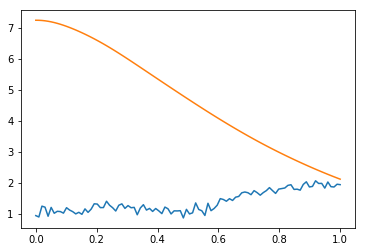

19/30 rows complete
Optimization restart 1/5, f = -71.91756328003268
Optimization restart 2/5, f = -71.22293892513129
Optimization restart 3/5, f = -68.79327107323266
Optimization restart 4/5, f = -70.74067478775956
Optimization restart 5/5, f = -68.79327994715251

Probability Sales Increasing is: 0.22
Sales Increasing: False


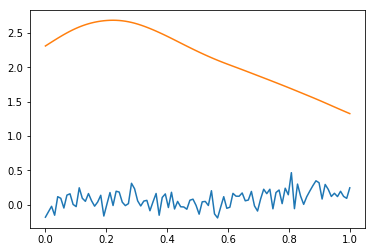

20/30 rows complete
Optimization restart 1/5, f = 3.2219113462763644
Optimization restart 2/5, f = 6.7071858854915405
Optimization restart 3/5, f = 3.2648630306337623
Optimization restart 4/5, f = 3.591023753584018
Optimization restart 5/5, f = 2.5925036021097156

Probability Sales Increasing is: 0.0
Sales Increasing: False


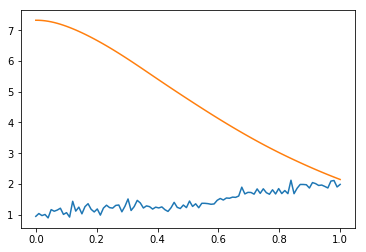

21/30 rows complete
Optimization restart 1/5, f = -76.38070632107923
Optimization restart 2/5, f = -76.3184877804701
Optimization restart 3/5, f = -76.3247633608866
Optimization restart 4/5, f = -76.881345544574
Optimization restart 5/5, f = -76.89043952687351

Probability Sales Increasing is: 0.36
Sales Increasing: False


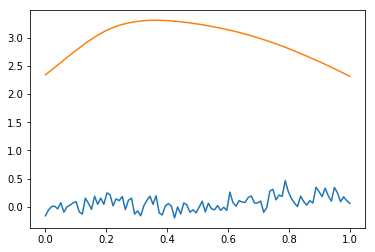

22/30 rows complete
Optimization restart 1/5, f = -43.86629022134603
Optimization restart 2/5, f = -20.090211601530974
Optimization restart 3/5, f = -40.723455488806614
Optimization restart 4/5, f = -40.75032306558374
Optimization restart 5/5, f = -43.86629022199563

Probability Sales Increasing is: 0.99
Sales Increasing: True


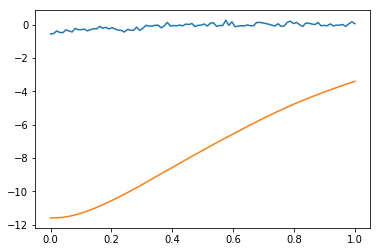

23/30 rows complete
Optimization restart 1/5, f = -43.834574475753875
Optimization restart 2/5, f = -47.574378828881656
Optimization restart 3/5, f = -45.8307210206591
Optimization restart 4/5, f = -47.07365048309997
Optimization restart 5/5, f = 65.4367690724103

Probability Sales Increasing is: 0.04
Sales Increasing: False


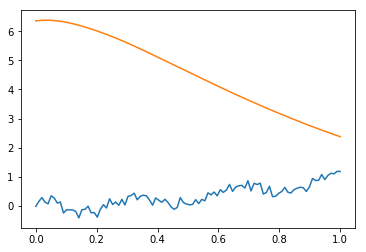

24/30 rows complete
Optimization restart 1/5, f = -0.6443511321591586
Optimization restart 2/5, f = 109.34505578416855
Optimization restart 3/5, f = -1.4923023561756708
Optimization restart 4/5, f = 5.254198481144407
Optimization restart 5/5, f = -1.509758019387938

Probability Sales Increasing is: 1.0
Sales Increasing: True


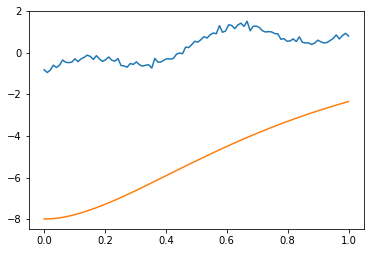

25/30 rows complete
Optimization restart 1/5, f = -81.62819162098074
Optimization restart 2/5, f = -81.89345605757441
Optimization restart 3/5, f = -78.99546967096914
Optimization restart 4/5, f = -81.89347246849132
Optimization restart 5/5, f = -81.54854006409144

Probability Sales Increasing is: 0.61
Sales Increasing: False


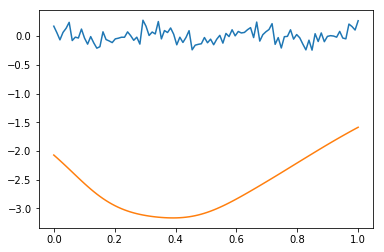

26/30 rows complete
Optimization restart 1/5, f = -89.38398848533679
Optimization restart 2/5, f = -92.27145651036128
Optimization restart 3/5, f = -92.27145509561356
Optimization restart 4/5, f = -92.00794580075922
Optimization restart 5/5, f = -92.00794583142064

Probability Sales Increasing is: 0.33
Sales Increasing: False


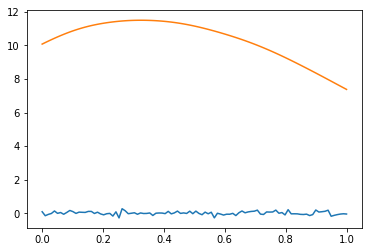

27/30 rows complete
Optimization restart 1/5, f = 2.1075427172263588
Optimization restart 2/5, f = 2.107542717055864
Optimization restart 3/5, f = 178.54606553487932
Optimization restart 4/5, f = 2.107542717126094
Optimization restart 5/5, f = 0.9190919360847118

Probability Sales Increasing is: 0.0
Sales Increasing: False


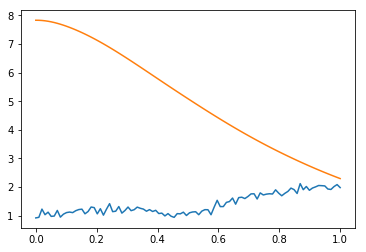

28/30 rows complete
Optimization restart 1/5, f = -100.29670931211925
Optimization restart 2/5, f = -100.12059927934149
Optimization restart 3/5, f = -100.57995446737405
Optimization restart 4/5, f = -98.96297660516694
Optimization restart 5/5, f = -103.54385665943641

Probability Sales Increasing is: 0.53
Sales Increasing: False


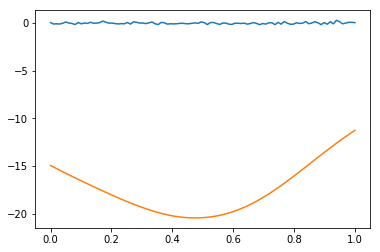

29/30 rows complete
Optimization restart 1/5, f = -90.48337841652017
Optimization restart 2/5, f = -89.32505217825945
Optimization restart 3/5, f = -89.10439082848464
Optimization restart 4/5, f = -88.83243889015161
Optimization restart 5/5, f = -81.78341323919537

Probability Sales Increasing is: 0.01
Sales Increasing: False


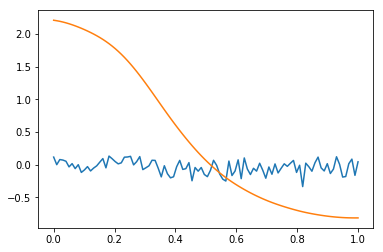

30/30 rows complete
     Id Category
0   120        0
1   121        0
2   122        1
3   123        0
4   124        1
5   125        0
6   126        0
7   127        1
8   128        0
9   129        0
10  130        0
11  131        1
12  132        0
13  133        0
14  134        0
15  135        0
16  136        1
17  137        0
18  138        0
19  139        0
20  140        0
21  141        0
22  142        1
23  143        0
24  144        1
25  145        0
26  146        0
27  147        0
28  148        0
29  149        0


In [23]:
# Run model on subset of rows
rows = train_df.shape[0] - 45
Decision = make_decision(train_df, run_model_gpy, rows)
Decision.to_csv('submission_gpy.csv')
print(Decision)

In [24]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

actual = train_df.head(rows)['Category'].values
predicted = np.array(Decision['Category'].values.astype(int))

combined = pd.DataFrame(data=np.c_[actual.reshape(-1, 1), predicted.reshape(-1, 1)], columns=['actual', 'predicted'])
combined

,actual,predicted
0,0,0
1,0,0
2,0,1
3,1,0
4,1,1
5,1,0
6,1,0
7,1,1
8,0,0
9,0,0


In [25]:
print(f'Confusion Matrix:\n{confusion_matrix(actual, predicted)}\n')
print(f'Accuracy Score:\n{accuracy_score(actual, predicted)}\n')
print ('Classification Report:')
print (classification_report(actual, predicted))

Confusion Matrix:
[[19  4]
 [ 4  3]]

Accuracy Score:
0.7333333333333333

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        23
           1       0.43      0.43      0.43         7

   micro avg       0.73      0.73      0.73        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.73      0.73      0.73        30



### Applying GPy model to test dataset

Optimization restart 1/5, f = 2.4274131550961826
Optimization restart 2/5, f = 4.688950354574693
Optimization restart 3/5, f = 2.045229251902988
Optimization restart 4/5, f = 184.16648376059857
Optimization restart 5/5, f = 2.427413155051269

Probability Sales Increasing is: 0.0
Sales Increasing: False


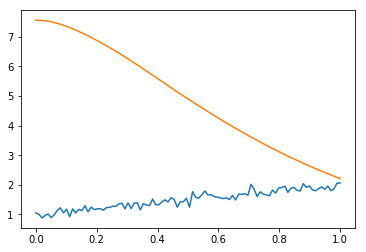

1/120 rows complete
Optimization restart 1/5, f = -85.71595502662946
Optimization restart 2/5, f = -58.42375327597634
Optimization restart 3/5, f = -84.88792639755331
Optimization restart 4/5, f = -85.13196494903048
Optimization restart 5/5, f = -85.13195945484276

Probability Sales Increasing is: 1.0
Sales Increasing: True


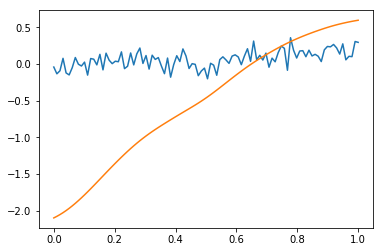

2/120 rows complete
Optimization restart 1/5, f = -88.78436675644164
Optimization restart 2/5, f = -87.50140034397171
Optimization restart 3/5, f = -87.65701193835997
Optimization restart 4/5, f = -59.268208229583756
Optimization restart 5/5, f = -85.22135527963468

Probability Sales Increasing is: 0.31
Sales Increasing: False


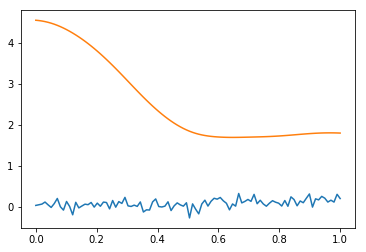

3/120 rows complete
Optimization restart 1/5, f = -88.36822075270322
Optimization restart 2/5, f = -88.33859353763734
Optimization restart 3/5, f = -88.08223016161304
Optimization restart 4/5, f = -88.40780654080214
Optimization restart 5/5, f = -88.01025920865801

Probability Sales Increasing is: 0.57
Sales Increasing: False


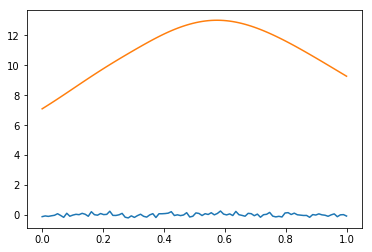

4/120 rows complete
Optimization restart 1/5, f = 10.416618884936085
Optimization restart 2/5, f = 46.052150407689936
Optimization restart 3/5, f = 9.471978735118554
Optimization restart 4/5, f = 11.74988420917201
Optimization restart 5/5, f = 9.56572212513965

Probability Sales Increasing is: 0.0
Sales Increasing: False


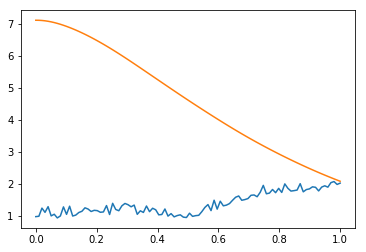

5/120 rows complete
Optimization restart 1/5, f = -69.04612459668346
Optimization restart 2/5, f = -73.11378417891157
Optimization restart 3/5, f = -73.19244942984395
Optimization restart 4/5, f = -69.04613017872158
Optimization restart 5/5, f = -69.04613020708142

Probability Sales Increasing is: 0.02
Sales Increasing: False


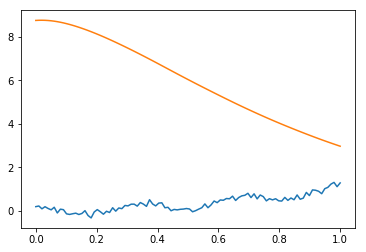

6/120 rows complete
Optimization restart 1/5, f = -81.6349995094137
Optimization restart 2/5, f = -82.58792259757551
Optimization restart 3/5, f = -82.44371652205527
Optimization restart 4/5, f = -82.4437200145558
Optimization restart 5/5, f = 1.6660380331800013

Probability Sales Increasing is: 0.73
Sales Increasing: False


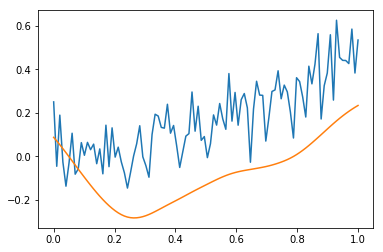

7/120 rows complete
Optimization restart 1/5, f = -88.02174932912962
Optimization restart 2/5, f = -88.08567288573528
Optimization restart 3/5, f = -88.08620904831986
Optimization restart 4/5, f = -88.00158489700678
Optimization restart 5/5, f = -87.47291138978159

Probability Sales Increasing is: 1.0
Sales Increasing: True


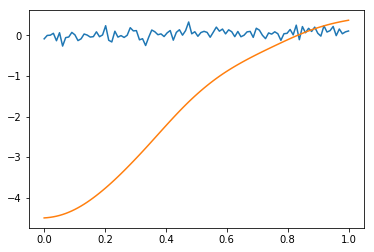

8/120 rows complete
Optimization restart 1/5, f = -76.54276354690525
Optimization restart 2/5, f = -76.56667956494857
Optimization restart 3/5, f = -77.34008931650567
Optimization restart 4/5, f = -45.57736559525579
Optimization restart 5/5, f = -48.672360941934116

Probability Sales Increasing is: 0.05
Sales Increasing: False


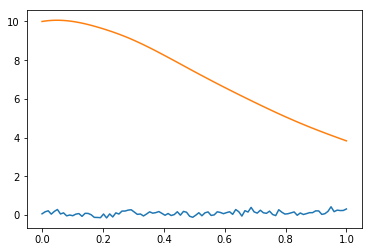

9/120 rows complete
Optimization restart 1/5, f = -2.7845504120971754
Optimization restart 2/5, f = -15.53004315570881
Optimization restart 3/5, f = -3.877147231371943
Optimization restart 4/5, f = -3.0991907146796436
Optimization restart 5/5, f = -3.1174735182628694

Probability Sales Increasing is: 1.0
Sales Increasing: True


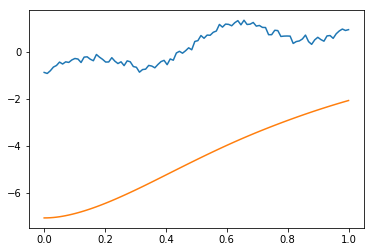

10/120 rows complete
Optimization restart 1/5, f = 11.956794394002792
Optimization restart 2/5, f = 11.845311341875842
Optimization restart 3/5, f = 181.6255193515202
Optimization restart 4/5, f = 181.62565317638268
Optimization restart 5/5, f = 57.00728923461172

Probability Sales Increasing is: 0.0
Sales Increasing: False


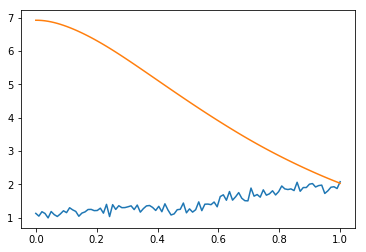

11/120 rows complete
Optimization restart 1/5, f = -79.44196630589343
Optimization restart 2/5, f = -75.6998015450242
Optimization restart 3/5, f = -78.03264478711705
Optimization restart 4/5, f = -76.92875257805639
Optimization restart 5/5, f = -79.7011442839688

Probability Sales Increasing is: 0.97
Sales Increasing: True


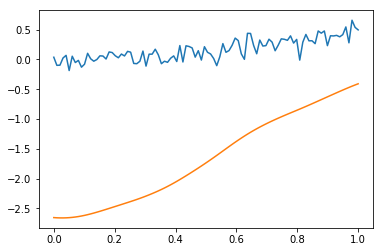

12/120 rows complete
Optimization restart 1/5, f = -61.270170046426465
Optimization restart 2/5, f = -64.97822767407237
Optimization restart 3/5, f = -65.27333240327668
Optimization restart 4/5, f = -65.12987021178907
Optimization restart 5/5, f = -65.12987021633825

Probability Sales Increasing is: 0.03
Sales Increasing: False


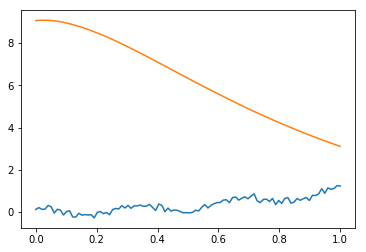

13/120 rows complete
Optimization restart 1/5, f = -87.77660729000517
Optimization restart 2/5, f = -84.20303932183586
Optimization restart 3/5, f = -87.77662623944678
Optimization restart 4/5, f = -84.66299465215776
Optimization restart 5/5, f = -83.89983125598228

Probability Sales Increasing is: 0.12
Sales Increasing: False


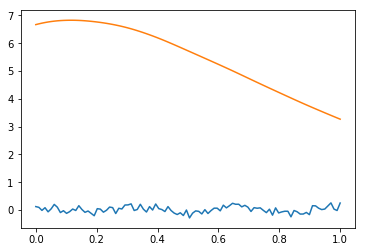

14/120 rows complete
Optimization restart 1/5, f = -73.194286671188
Optimization restart 2/5, f = -69.19359841772203
Optimization restart 3/5, f = -73.44755285799981
Optimization restart 4/5, f = -69.19373491436994
Optimization restart 5/5, f = -73.58475677896813

Probability Sales Increasing is: 0.34
Sales Increasing: False


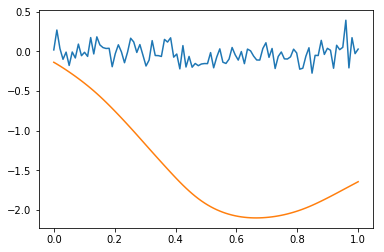

15/120 rows complete
Optimization restart 1/5, f = -91.01842802196683
Optimization restart 2/5, f = -89.88739545930787
Optimization restart 3/5, f = -88.64620038936368
Optimization restart 4/5, f = -85.28225448684023
Optimization restart 5/5, f = -86.84280417055098

Probability Sales Increasing is: 0.95
Sales Increasing: True


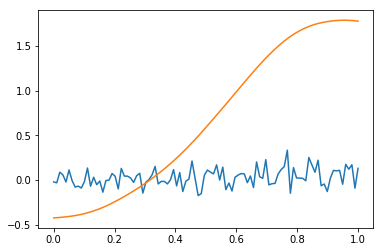

16/120 rows complete
Optimization restart 1/5, f = -66.04196172120697
Optimization restart 2/5, f = -64.51584610621595
Optimization restart 3/5, f = -64.53824631011545
Optimization restart 4/5, f = -66.17875269278045
Optimization restart 5/5, f = -64.53573583009342

Probability Sales Increasing is: 1.0
Sales Increasing: True


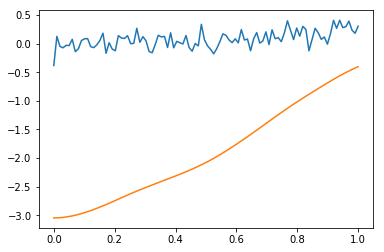

17/120 rows complete
Optimization restart 1/5, f = -72.11282945075314
Optimization restart 2/5, f = -71.25781406439074
Optimization restart 3/5, f = -40.61598036225934
Optimization restart 4/5, f = -73.43255710423054
Optimization restart 5/5, f = -71.57461231000096

Probability Sales Increasing is: 0.05
Sales Increasing: False


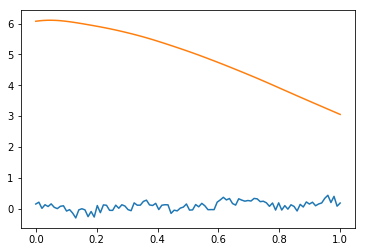

18/120 rows complete
Optimization restart 1/5, f = -81.84716893678024
Optimization restart 2/5, f = -81.942511753249
Optimization restart 3/5, f = -81.44915868694335
Optimization restart 4/5, f = -81.94251175489055
Optimization restart 5/5, f = -81.92648453457855

Probability Sales Increasing is: 0.9
Sales Increasing: True


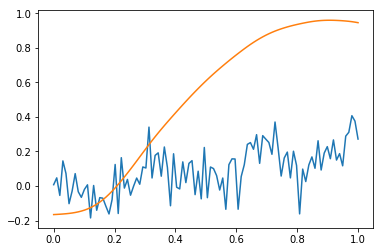

19/120 rows complete
Optimization restart 1/5, f = -80.2050499007593
Optimization restart 2/5, f = -77.58002876951342
Optimization restart 3/5, f = -76.76264853384937
Optimization restart 4/5, f = -77.95958418700474
Optimization restart 5/5, f = -80.30211525514872

Probability Sales Increasing is: 0.98
Sales Increasing: True


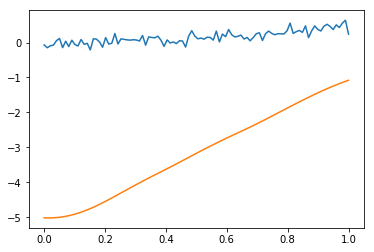

20/120 rows complete
Optimization restart 1/5, f = -77.20594921714059
Optimization restart 2/5, f = -73.97376102741764
Optimization restart 3/5, f = -79.30079110048814
Optimization restart 4/5, f = -79.30104858762493
Optimization restart 5/5, f = -73.93204863824042

Probability Sales Increasing is: 0.97
Sales Increasing: True


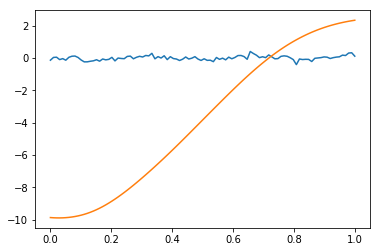

21/120 rows complete
Optimization restart 1/5, f = -72.54133922903142
Optimization restart 2/5, f = -72.92304698058042
Optimization restart 3/5, f = -71.1372878593269
Optimization restart 4/5, f = -73.28513893818733
Optimization restart 5/5, f = -70.29966150845152

Probability Sales Increasing is: 0.54
Sales Increasing: False


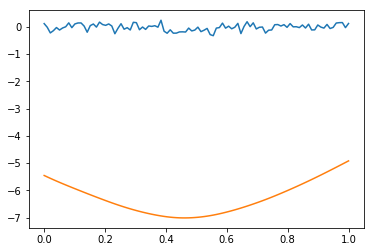

22/120 rows complete
Optimization restart 1/5, f = -81.30539123881778
Optimization restart 2/5, f = -83.57484079018386
Optimization restart 3/5, f = -85.77502814898776
Optimization restart 4/5, f = -82.4766877575442
Optimization restart 5/5, f = -83.57483829846166

Probability Sales Increasing is: 0.52
Sales Increasing: False


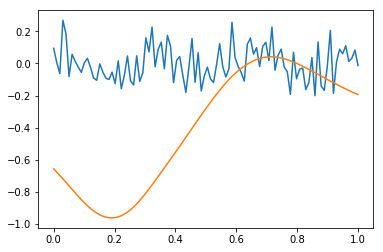

23/120 rows complete
Optimization restart 1/5, f = -65.60925117316026
Optimization restart 2/5, f = -65.74252718036612
Optimization restart 3/5, f = -38.539288815718294
Optimization restart 4/5, f = -65.81174917939347
Optimization restart 5/5, f = -65.8117491794693

Probability Sales Increasing is: 0.09
Sales Increasing: False


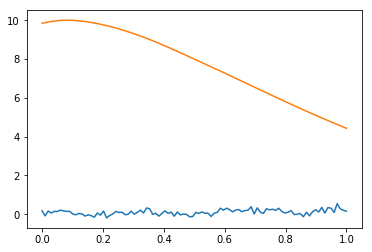

24/120 rows complete
Optimization restart 1/5, f = -73.89077957146158
Optimization restart 2/5, f = -74.1217323847167
Optimization restart 3/5, f = -74.10809574654934
Optimization restart 4/5, f = -36.22961325037611
Optimization restart 5/5, f = -74.10809499659817

Probability Sales Increasing is: 0.11
Sales Increasing: False


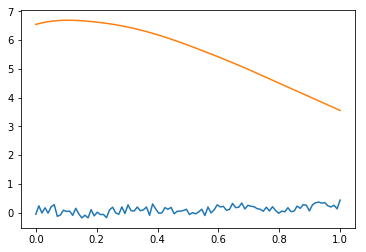

25/120 rows complete
Optimization restart 1/5, f = -95.8455713267833
Optimization restart 2/5, f = -93.52721050084945
Optimization restart 3/5, f = -91.52883473377369
Optimization restart 4/5, f = -94.91898543355606
Optimization restart 5/5, f = -85.34627628878533

Probability Sales Increasing is: 0.1
Sales Increasing: False


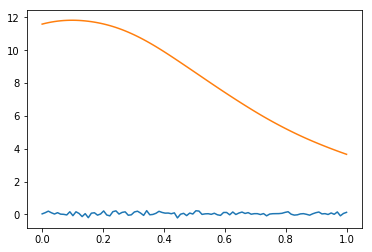

26/120 rows complete
Optimization restart 1/5, f = -70.25201030474913
Optimization restart 2/5, f = -71.15849729642879
Optimization restart 3/5, f = -70.28100251931397
Optimization restart 4/5, f = -71.5722634825315
Optimization restart 5/5, f = -40.44854768912699

Probability Sales Increasing is: 0.17
Sales Increasing: False


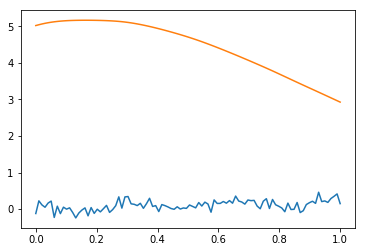

27/120 rows complete
Optimization restart 1/5, f = -82.52476781535094
Optimization restart 2/5, f = -82.60370370536202
Optimization restart 3/5, f = -82.16421600894171
Optimization restart 4/5, f = -82.16421179613518
Optimization restart 5/5, f = -81.44010642637886

Probability Sales Increasing is: 0.95
Sales Increasing: True


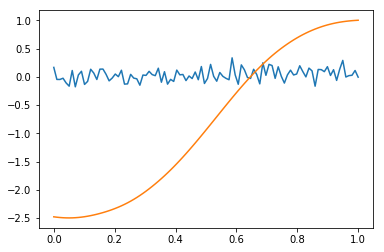

28/120 rows complete
Optimization restart 1/5, f = -59.476338743314344
Optimization restart 2/5, f = -63.14013221485822
Optimization restart 3/5, f = -63.14013221043021
Optimization restart 4/5, f = 38.62429553692961
Optimization restart 5/5, f = -63.140132215006155

Probability Sales Increasing is: 0.02
Sales Increasing: False


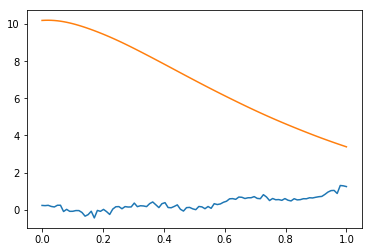

29/120 rows complete
Optimization restart 1/5, f = 6.292294332230661
Optimization restart 2/5, f = -8.469823519288525
Optimization restart 3/5, f = 184.50145820302453
Optimization restart 4/5, f = 96.22552213287801
Optimization restart 5/5, f = -7.457596893775062

Probability Sales Increasing is: 0.0
Sales Increasing: False


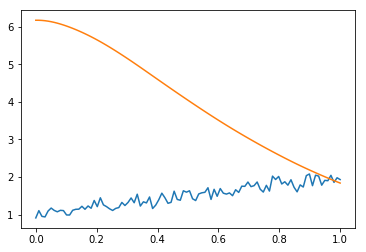

30/120 rows complete
Optimization restart 1/5, f = 0.7710656565750966
Optimization restart 2/5, f = 184.3283564199656
Optimization restart 3/5, f = 0.8589895279980837
Optimization restart 4/5, f = 1.047865211350313
Optimization restart 5/5, f = 0.7710656565845326

Probability Sales Increasing is: 0.0
Sales Increasing: False


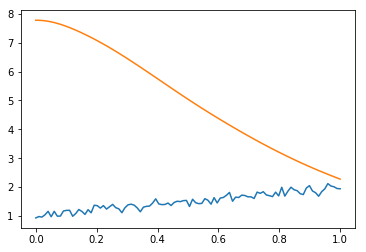

31/120 rows complete
Optimization restart 1/5, f = -83.28473238166019
Optimization restart 2/5, f = -80.62886644148696
Optimization restart 3/5, f = -80.00291833414624
Optimization restart 4/5, f = -83.28474839041291
Optimization restart 5/5, f = -68.58158520327265

Probability Sales Increasing is: 0.98
Sales Increasing: True


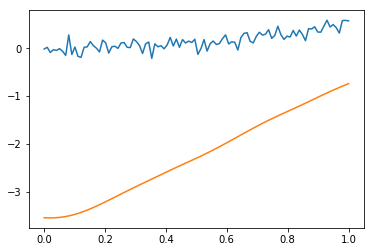

32/120 rows complete
Optimization restart 1/5, f = 8.269359936907605
Optimization restart 2/5, f = 9.052296083468242
Optimization restart 3/5, f = 0.3302310619130111
Optimization restart 4/5, f = 9.071519495611767
Optimization restart 5/5, f = 9.052296083628832

Probability Sales Increasing is: 0.01
Sales Increasing: False


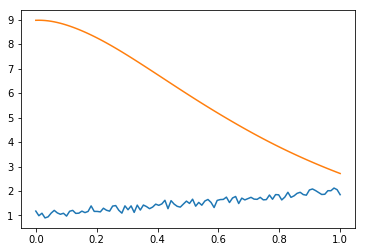

33/120 rows complete
Optimization restart 1/5, f = 2.7025063731488643
Optimization restart 2/5, f = 184.47363134005238
Optimization restart 3/5, f = 3.0528547416477068
Optimization restart 4/5, f = 2.7471848045419236
Optimization restart 5/5, f = 184.47356701514911

Probability Sales Increasing is: 0.0
Sales Increasing: False


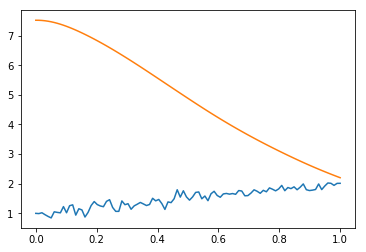

34/120 rows complete
Optimization restart 1/5, f = -76.60460519190764
Optimization restart 2/5, f = -71.82585177743165
Optimization restart 3/5, f = -74.03457357784497
Optimization restart 4/5, f = -73.98670631756896
Optimization restart 5/5, f = -76.60461205175605

Probability Sales Increasing is: 0.11
Sales Increasing: False


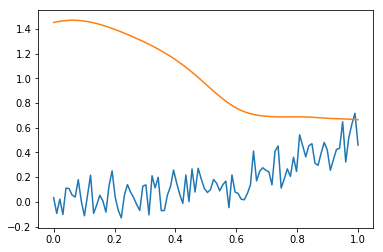

35/120 rows complete
Optimization restart 1/5, f = 9.480302545272139
Optimization restart 2/5, f = 31.835170994607026
Optimization restart 3/5, f = 185.24139773524413
Optimization restart 4/5, f = 8.995015682318197
Optimization restart 5/5, f = 8.99550587462359

Probability Sales Increasing is: 0.0
Sales Increasing: False


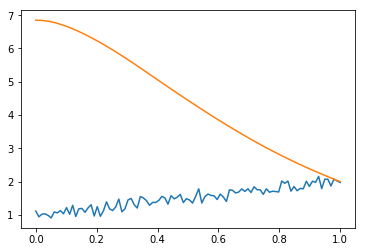

36/120 rows complete
Optimization restart 1/5, f = 8.978188590181496
Optimization restart 2/5, f = 177.01303446745897
Optimization restart 3/5, f = -2.7394886544981745
Optimization restart 4/5, f = 8.97818856796571
Optimization restart 5/5, f = 8.978188712570365

Probability Sales Increasing is: 0.0
Sales Increasing: False


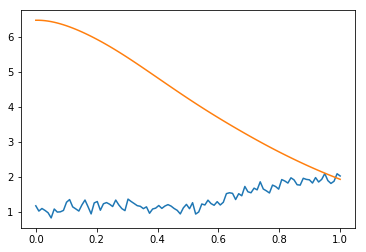

37/120 rows complete
Optimization restart 1/5, f = -82.1391887430238
Optimization restart 2/5, f = -82.10410453885879
Optimization restart 3/5, f = -82.1041046941834
Optimization restart 4/5, f = -82.6297382949372
Optimization restart 5/5, f = -82.62917825627969

Probability Sales Increasing is: 0.71
Sales Increasing: False


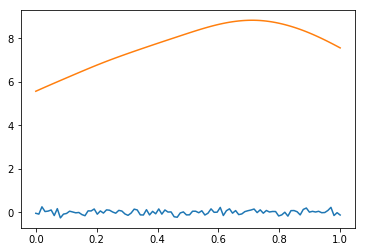

38/120 rows complete
Optimization restart 1/5, f = -1.344083823765203
Optimization restart 2/5, f = 66.15684930554622
Optimization restart 3/5, f = -17.00912412822054
Optimization restart 4/5, f = -1.7539743792419316
Optimization restart 5/5, f = -1.0965450499092313

Probability Sales Increasing is: 0.0
Sales Increasing: False


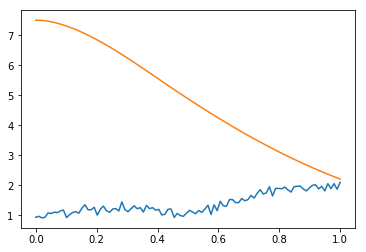

39/120 rows complete
Optimization restart 1/5, f = -87.24992001675174
Optimization restart 2/5, f = -85.35341943331659
Optimization restart 3/5, f = -87.27713550763426
Optimization restart 4/5, f = -86.2088478862407
Optimization restart 5/5, f = -87.26142046484195

Probability Sales Increasing is: 0.73
Sales Increasing: False


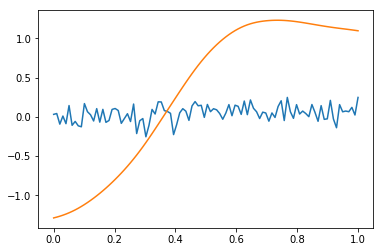

40/120 rows complete
Optimization restart 1/5, f = 5.1281114260428
Optimization restart 2/5, f = 4.9842257736498965
Optimization restart 3/5, f = 5.021714547726354
Optimization restart 4/5, f = 5.42924312958241
Optimization restart 5/5, f = 5.429243129268819

Probability Sales Increasing is: 0.0
Sales Increasing: False


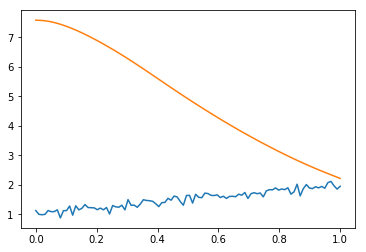

41/120 rows complete
Optimization restart 1/5, f = -88.20688494015485
Optimization restart 2/5, f = -73.66712301838943
Optimization restart 3/5, f = -74.35918611923691
Optimization restart 4/5, f = -86.72830020246326
Optimization restart 5/5, f = -73.82066124709795

Probability Sales Increasing is: 0.44
Sales Increasing: False


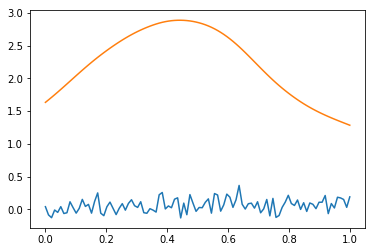

42/120 rows complete
Optimization restart 1/5, f = -89.64721800929192
Optimization restart 2/5, f = -89.21515444057674
Optimization restart 3/5, f = -88.01020165726452
Optimization restart 4/5, f = -59.11937353964956
Optimization restart 5/5, f = -89.85716619022105

Probability Sales Increasing is: 0.26
Sales Increasing: False


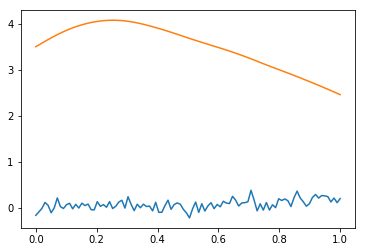

43/120 rows complete
Optimization restart 1/5, f = -85.58565853485955
Optimization restart 2/5, f = -86.37598591511559
Optimization restart 3/5, f = -86.36055692895144
Optimization restart 4/5, f = -85.58566226690995
Optimization restart 5/5, f = -88.5326559552912

Probability Sales Increasing is: 0.05
Sales Increasing: False


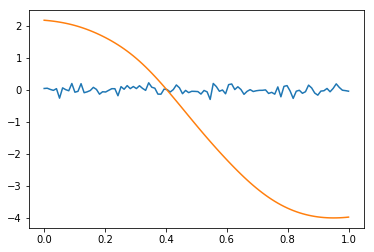

44/120 rows complete
Optimization restart 1/5, f = -54.68703968513561
Optimization restart 2/5, f = -57.494342407523746
Optimization restart 3/5, f = -57.42903370453128
Optimization restart 4/5, f = -57.515073336802764
Optimization restart 5/5, f = -57.51507371457096

Probability Sales Increasing is: 0.03
Sales Increasing: False


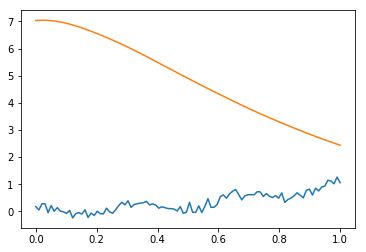

45/120 rows complete
Optimization restart 1/5, f = 5.064107330860068
Optimization restart 2/5, f = 5.79093450065384
Optimization restart 3/5, f = 5.619278006403846
Optimization restart 4/5, f = -0.019106509877538258
Optimization restart 5/5, f = -10.856204462104039

Probability Sales Increasing is: 0.0
Sales Increasing: False


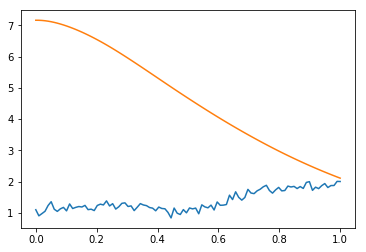

46/120 rows complete
Optimization restart 1/5, f = -69.28235822663683
Optimization restart 2/5, f = -69.22724288994331
Optimization restart 3/5, f = -68.88426610607928
Optimization restart 4/5, f = -40.82012968094801
Optimization restart 5/5, f = -70.03764710421349

Probability Sales Increasing is: 0.07
Sales Increasing: False


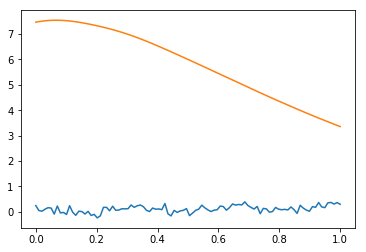

47/120 rows complete
Optimization restart 1/5, f = -4.938296379266156
Optimization restart 2/5, f = -21.231318280616264
Optimization restart 3/5, f = 120.07044443410913
Optimization restart 4/5, f = 102.18323734659452
Optimization restart 5/5, f = -16.833129518868816

Probability Sales Increasing is: 0.0
Sales Increasing: False


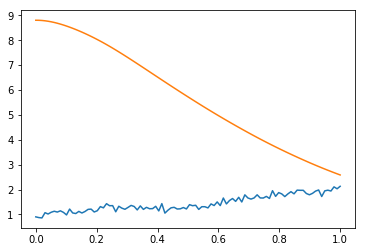

48/120 rows complete
Optimization restart 1/5, f = -79.9878117630818
Optimization restart 2/5, f = -79.08531716365272
Optimization restart 3/5, f = -78.81492688991777
Optimization restart 4/5, f = -78.9920692566782
Optimization restart 5/5, f = -79.96402959532588

Probability Sales Increasing is: 0.43
Sales Increasing: False


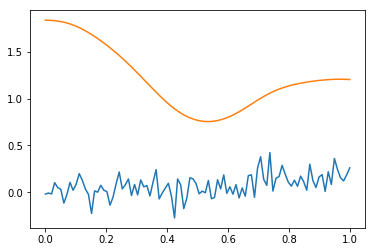

49/120 rows complete
Optimization restart 1/5, f = -76.44589641120712
Optimization restart 2/5, f = -74.4765855715334
Optimization restart 3/5, f = -74.4778338598855
Optimization restart 4/5, f = -74.39267316049529
Optimization restart 5/5, f = -74.60557206886071

Probability Sales Increasing is: 0.81
Sales Increasing: True


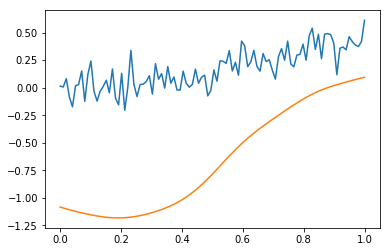

50/120 rows complete
Optimization restart 1/5, f = -6.038109689804735
Optimization restart 2/5, f = -7.160799952938845
Optimization restart 3/5, f = -6.350186434090951
Optimization restart 4/5, f = -6.350186434065307
Optimization restart 5/5, f = -6.331189213483874

Probability Sales Increasing is: 1.0
Sales Increasing: True


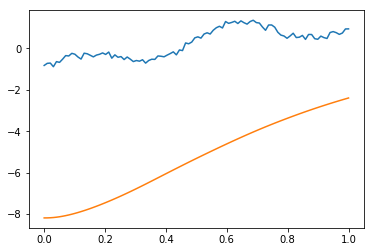

51/120 rows complete
Optimization restart 1/5, f = 13.28762691790152
Optimization restart 2/5, f = 180.9283090009023
Optimization restart 3/5, f = 13.123952478657941
Optimization restart 4/5, f = 13.123952478396525
Optimization restart 5/5, f = 12.84518595242453

Probability Sales Increasing is: 0.0
Sales Increasing: False


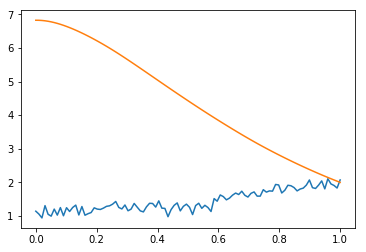

52/120 rows complete
Optimization restart 1/5, f = -81.46959906499765
Optimization restart 2/5, f = -81.83490122438558
Optimization restart 3/5, f = -81.82237255035014
Optimization restart 4/5, f = -81.52905941760403
Optimization restart 5/5, f = -81.42005662607446

Probability Sales Increasing is: 1.0
Sales Increasing: True


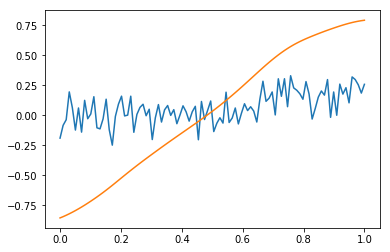

53/120 rows complete
Optimization restart 1/5, f = -98.94128362477204
Optimization restart 2/5, f = -87.41420147311672
Optimization restart 3/5, f = -91.96426735742017
Optimization restart 4/5, f = -98.4251808579713
Optimization restart 5/5, f = -98.61171672820731

Probability Sales Increasing is: 0.85
Sales Increasing: True


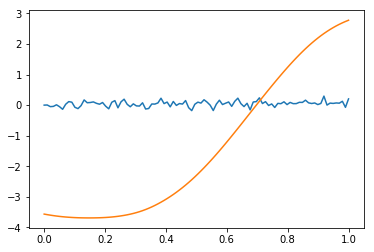

54/120 rows complete
Optimization restart 1/5, f = 4.959379874502929
Optimization restart 2/5, f = 3.636450429415383
Optimization restart 3/5, f = 3.636440501565744
Optimization restart 4/5, f = 18.887227305014036
Optimization restart 5/5, f = 3.629209086687162

Probability Sales Increasing is: 0.99
Sales Increasing: True


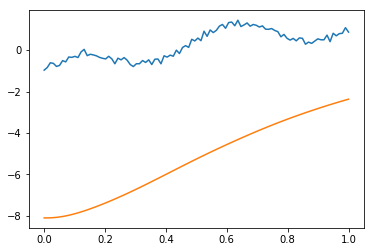

55/120 rows complete
Optimization restart 1/5, f = -91.34979097221333
Optimization restart 2/5, f = -91.04914781722061
Optimization restart 3/5, f = -91.04914786093198
Optimization restart 4/5, f = -42.79838737507132
Optimization restart 5/5, f = -42.79840134622099

Probability Sales Increasing is: 0.04
Sales Increasing: False


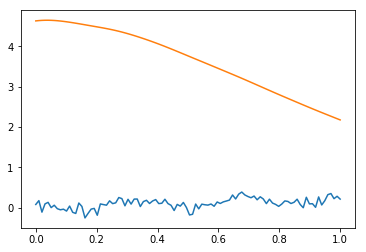

56/120 rows complete
Optimization restart 1/5, f = -64.3129946593047
Optimization restart 2/5, f = -64.26836090712837
Optimization restart 3/5, f = -64.1913648574401
Optimization restart 4/5, f = -64.26554015985654
Optimization restart 5/5, f = -64.42896887095858

Probability Sales Increasing is: 0.06
Sales Increasing: False


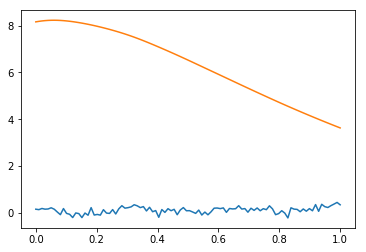

57/120 rows complete
Optimization restart 1/5, f = -32.198091046950324
Optimization restart 2/5, f = -13.130682361978941
Optimization restart 3/5, f = -13.130682352132176
Optimization restart 4/5, f = -13.130682352726026
Optimization restart 5/5, f = -32.19809340124121

Probability Sales Increasing is: 0.98
Sales Increasing: True


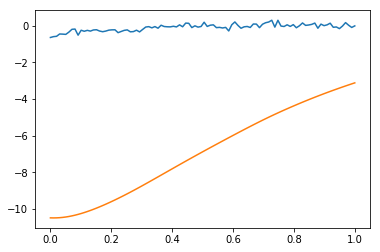

58/120 rows complete
Optimization restart 1/5, f = 5.420379048933768
Optimization restart 2/5, f = 5.379684558231901
Optimization restart 3/5, f = 5.420379048951382
Optimization restart 4/5, f = 4.72325879264195
Optimization restart 5/5, f = 180.58620572661044

Probability Sales Increasing is: 0.0
Sales Increasing: False


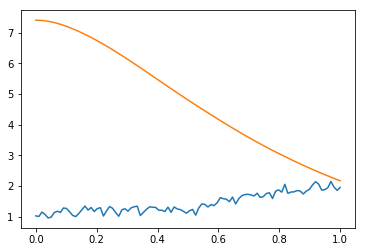

59/120 rows complete
Optimization restart 1/5, f = 4.426343992499959
Optimization restart 2/5, f = -1.588581287368612
Optimization restart 3/5, f = 16.987828966012767
Optimization restart 4/5, f = 3.476352869054992
Optimization restart 5/5, f = 3.476357009632842

Probability Sales Increasing is: 0.0
Sales Increasing: False


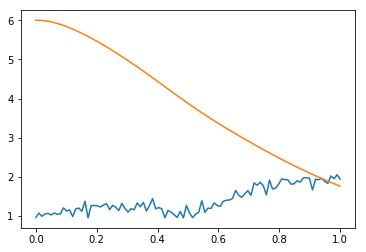

60/120 rows complete
Optimization restart 1/5, f = -80.93179986033611
Optimization restart 2/5, f = -80.88077745772907
Optimization restart 3/5, f = -80.92931544825828
Optimization restart 4/5, f = -77.14099144852136
Optimization restart 5/5, f = -76.39807881779578

Probability Sales Increasing is: 0.98
Sales Increasing: True


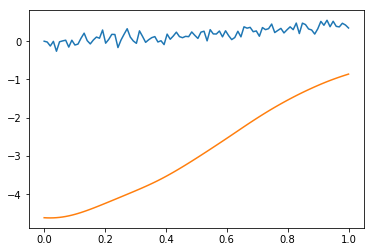

61/120 rows complete
Optimization restart 1/5, f = -5.461260493050673
Optimization restart 2/5, f = -5.461261417257894
Optimization restart 3/5, f = -6.700172267949931
Optimization restart 4/5, f = -6.551784874869611
Optimization restart 5/5, f = -6.700172440453713

Probability Sales Increasing is: 1.0
Sales Increasing: True


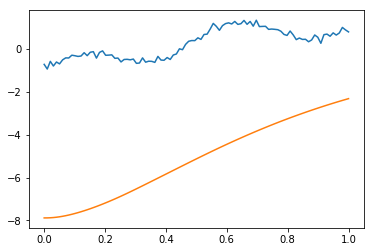

62/120 rows complete
Optimization restart 1/5, f = -35.08294339424082
Optimization restart 2/5, f = -12.684154696407155
Optimization restart 3/5, f = -40.78695489800639
Optimization restart 4/5, f = -32.46670077129386
Optimization restart 5/5, f = -12.647872895184207

Probability Sales Increasing is: 0.99
Sales Increasing: True


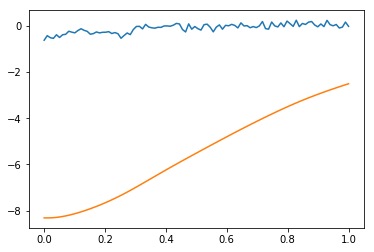

63/120 rows complete
Optimization restart 1/5, f = -95.05158421880526
Optimization restart 2/5, f = -94.35208866712364
Optimization restart 3/5, f = -92.59303837248399
Optimization restart 4/5, f = -94.54940700475244
Optimization restart 5/5, f = -93.70680413934832

Probability Sales Increasing is: 0.61
Sales Increasing: False


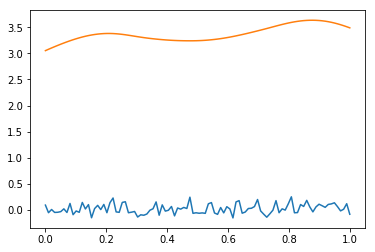

64/120 rows complete
Optimization restart 1/5, f = -89.96592451286523
Optimization restart 2/5, f = -82.2826624676224
Optimization restart 3/5, f = -88.49442524805814
Optimization restart 4/5, f = -89.20427328484149
Optimization restart 5/5, f = -88.8651018362008

Probability Sales Increasing is: 0.7
Sales Increasing: False


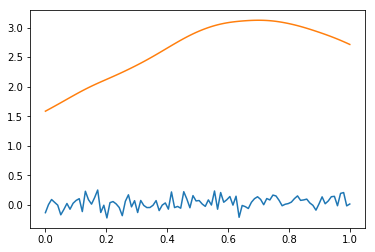

65/120 rows complete
Optimization restart 1/5, f = -9.17374654360458
Optimization restart 2/5, f = -9.170695205772752
Optimization restart 3/5, f = -4.161311282569734
Optimization restart 4/5, f = -6.953387946874585
Optimization restart 5/5, f = -9.107904680943037

Probability Sales Increasing is: 1.0
Sales Increasing: True


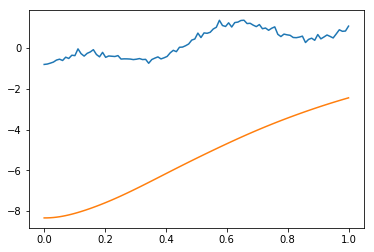

66/120 rows complete
Optimization restart 1/5, f = -41.95385241621844
Optimization restart 2/5, f = -48.26115666983438
Optimization restart 3/5, f = -37.82598535206343
Optimization restart 4/5, f = -17.740679653510263
Optimization restart 5/5, f = -43.60162668782518

Probability Sales Increasing is: 0.99
Sales Increasing: True


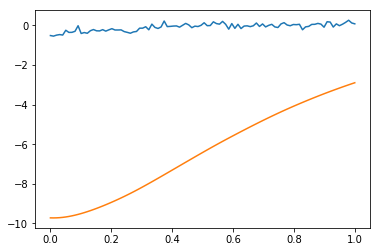

67/120 rows complete
Optimization restart 1/5, f = -31.618517554203926
Optimization restart 2/5, f = -12.258680053818964
Optimization restart 3/5, f = -38.23890625716022
Optimization restart 4/5, f = -31.21934167715291
Optimization restart 5/5, f = -35.831946971275194

Probability Sales Increasing is: 0.98
Sales Increasing: True


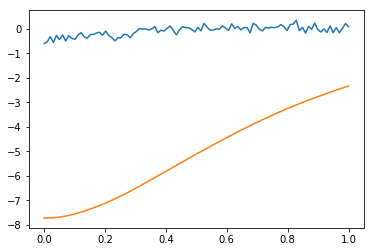

68/120 rows complete
Optimization restart 1/5, f = -82.89259760968581
Optimization restart 2/5, f = -84.6327997858015
Optimization restart 3/5, f = -81.8317670360594
Optimization restart 4/5, f = -84.0821278289157
Optimization restart 5/5, f = -84.49882662903241

Probability Sales Increasing is: 0.27
Sales Increasing: False


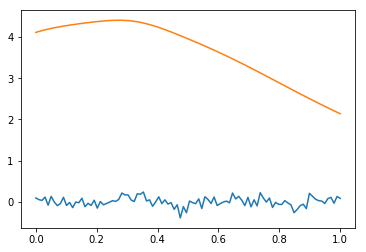

69/120 rows complete
Optimization restart 1/5, f = 3.8278083696130665
Optimization restart 2/5, f = -8.816057946675237
Optimization restart 3/5, f = 177.60233815826336
Optimization restart 4/5, f = 3.8278069695857724
Optimization restart 5/5, f = 3.8278084272528474

Probability Sales Increasing is: 0.0
Sales Increasing: False


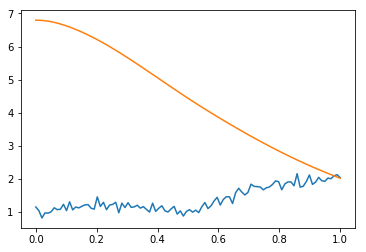

70/120 rows complete
Optimization restart 1/5, f = 0.40773003557605847
Optimization restart 2/5, f = 83.33077365906827
Optimization restart 3/5, f = 1.365714891456605
Optimization restart 4/5, f = 2.4416119886030287
Optimization restart 5/5, f = 80.95434766381213

Probability Sales Increasing is: 0.0
Sales Increasing: False


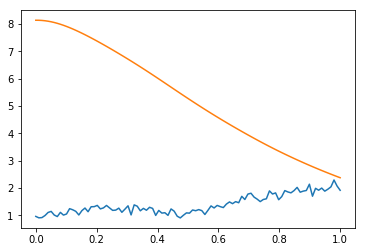

71/120 rows complete
Optimization restart 1/5, f = -81.00652131144389
Optimization restart 2/5, f = -78.49011035117465
Optimization restart 3/5, f = -79.59422554708682
Optimization restart 4/5, f = -77.74321317158044
Optimization restart 5/5, f = -79.59421698818852

Probability Sales Increasing is: 0.9
Sales Increasing: True


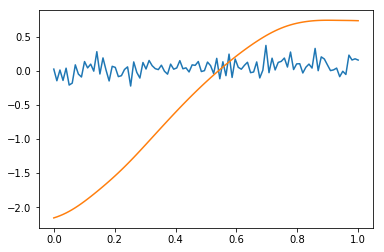

72/120 rows complete
Optimization restart 1/5, f = -83.9813901251324
Optimization restart 2/5, f = -83.98139315512121
Optimization restart 3/5, f = -83.98139389502913
Optimization restart 4/5, f = -83.98139529799852
Optimization restart 5/5, f = -83.98134081702

Probability Sales Increasing is: 0.06
Sales Increasing: False


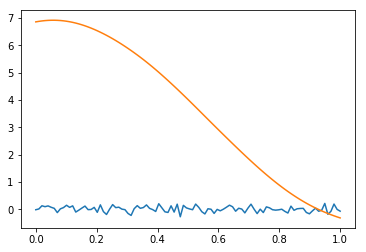

73/120 rows complete
Optimization restart 1/5, f = -43.48215627298819
Optimization restart 2/5, f = -37.44449441303085
Optimization restart 3/5, f = -25.12616384177241
Optimization restart 4/5, f = -25.1261593992353
Optimization restart 5/5, f = -36.39351378585483

Probability Sales Increasing is: 0.99
Sales Increasing: True


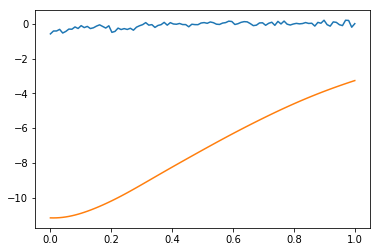

74/120 rows complete
Optimization restart 1/5, f = -48.70431279878266
Optimization restart 2/5, f = -13.36160674292966
Optimization restart 3/5, f = -55.1671069517447
Optimization restart 4/5, f = -55.16712563921066
Optimization restart 5/5, f = -55.167074791611434

Probability Sales Increasing is: 0.99
Sales Increasing: True


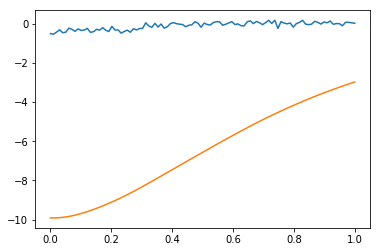

75/120 rows complete
Optimization restart 1/5, f = -54.594081480198334
Optimization restart 2/5, f = -58.81633337162059
Optimization restart 3/5, f = -58.585208106038806
Optimization restart 4/5, f = -58.949195048197325
Optimization restart 5/5, f = -58.92283697446334

Probability Sales Increasing is: 0.02
Sales Increasing: False


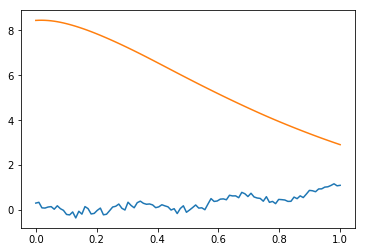

76/120 rows complete
Optimization restart 1/5, f = 3.2178500079965318
Optimization restart 2/5, f = 3.2178484078641745
Optimization restart 3/5, f = 176.68358879860688
Optimization restart 4/5, f = 176.68358995272519
Optimization restart 5/5, f = 3.2679221148458453

Probability Sales Increasing is: 0.0
Sales Increasing: False


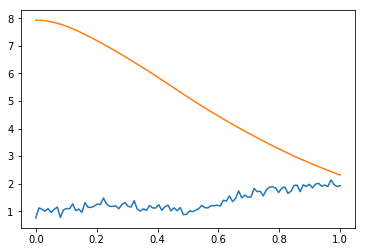

77/120 rows complete
Optimization restart 1/5, f = -81.58510548375007
Optimization restart 2/5, f = -81.96208970821775
Optimization restart 3/5, f = -80.09813795760512
Optimization restart 4/5, f = -83.80354356063711
Optimization restart 5/5, f = -69.4053249591765

Probability Sales Increasing is: 0.65
Sales Increasing: False


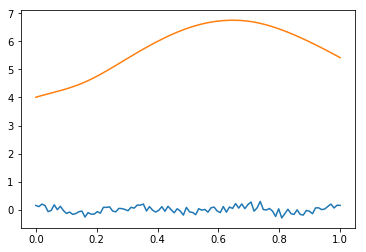

78/120 rows complete
Optimization restart 1/5, f = -91.27780234206506
Optimization restart 2/5, f = -92.35650985511771
Optimization restart 3/5, f = -91.22463194915804
Optimization restart 4/5, f = -87.81899096079579
Optimization restart 5/5, f = -87.81725792265026

Probability Sales Increasing is: 0.51
Sales Increasing: False


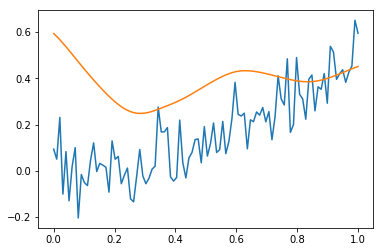

79/120 rows complete
Optimization restart 1/5, f = -29.93642904346597
Optimization restart 2/5, f = -27.869565038584177
Optimization restart 3/5, f = -7.441614760215735
Optimization restart 4/5, f = -27.590464556468618
Optimization restart 5/5, f = -27.869585554203915

Probability Sales Increasing is: 0.99
Sales Increasing: True


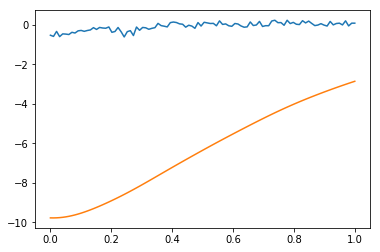

80/120 rows complete
Optimization restart 1/5, f = -48.64928237228364
Optimization restart 2/5, f = -52.193979128487896
Optimization restart 3/5, f = 53.81755159255371
Optimization restart 4/5, f = -11.30112294653765
Optimization restart 5/5, f = -52.204517450529316

Probability Sales Increasing is: 0.03
Sales Increasing: False


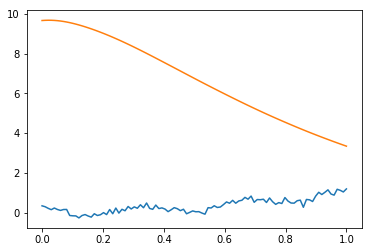

81/120 rows complete
Optimization restart 1/5, f = 3.927908467184764
Optimization restart 2/5, f = -6.82333121452487
Optimization restart 3/5, f = 3.9279084822443906
Optimization restart 4/5, f = 3.92790846838799
Optimization restart 5/5, f = 4.420307732021072

Probability Sales Increasing is: 0.01
Sales Increasing: False


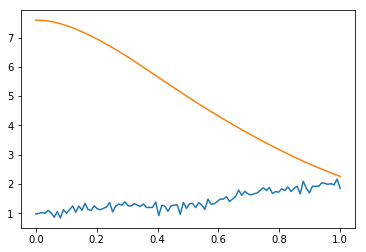

82/120 rows complete
Optimization restart 1/5, f = 6.167751024300628
Optimization restart 2/5, f = 24.437870984246118
Optimization restart 3/5, f = 6.29023579991631
Optimization restart 4/5, f = 51.857546855840035
Optimization restart 5/5, f = 162.9130372936948

Probability Sales Increasing is: 0.0
Sales Increasing: False


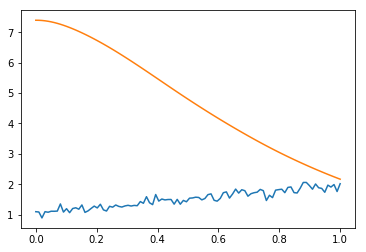

83/120 rows complete
Optimization restart 1/5, f = -1.131512749574668
Optimization restart 2/5, f = -2.206365158558519
Optimization restart 3/5, f = -2.206365157969948
Optimization restart 4/5, f = -2.2063651585571193
Optimization restart 5/5, f = -2.2241354175969406

Probability Sales Increasing is: 1.0
Sales Increasing: True


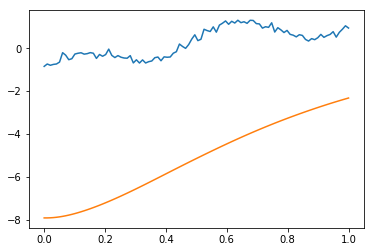

84/120 rows complete
Optimization restart 1/5, f = -88.41120506452296
Optimization restart 2/5, f = -73.91841932439368
Optimization restart 3/5, f = -87.89981284150042
Optimization restart 4/5, f = -88.41284325610087
Optimization restart 5/5, f = -88.31748593555405

Probability Sales Increasing is: 0.04
Sales Increasing: False


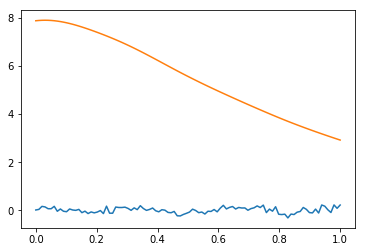

85/120 rows complete
Optimization restart 1/5, f = -83.03584901529737
Optimization restart 2/5, f = -80.74687554550479
Optimization restart 3/5, f = -84.35663029052303
Optimization restart 4/5, f = -80.97374098857964
Optimization restart 5/5, f = -77.5318634770704

Probability Sales Increasing is: 0.45
Sales Increasing: False


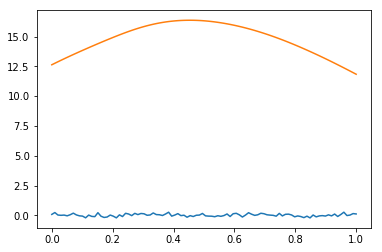

86/120 rows complete
Optimization restart 1/5, f = -91.04761299202237
Optimization restart 2/5, f = -91.03958145325137
Optimization restart 3/5, f = -90.64358469278372
Optimization restart 4/5, f = -91.06245387937227
Optimization restart 5/5, f = -91.08213769339534

Probability Sales Increasing is: 0.69
Sales Increasing: False


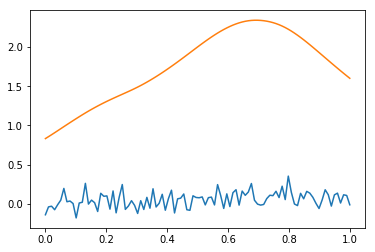

87/120 rows complete
Optimization restart 1/5, f = -80.71462993110401
Optimization restart 2/5, f = -80.89033731639145
Optimization restart 3/5, f = -80.50994699856716
Optimization restart 4/5, f = -75.46019798205825
Optimization restart 5/5, f = -75.4601978732304

Probability Sales Increasing is: 0.47
Sales Increasing: False


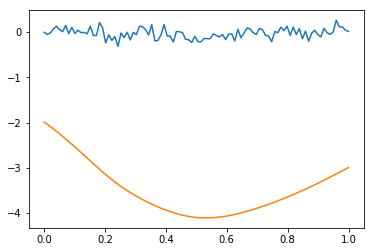

88/120 rows complete
Optimization restart 1/5, f = 8.881344604543166
Optimization restart 2/5, f = 8.881344604879956
Optimization restart 3/5, f = 180.71907584697453
Optimization restart 4/5, f = 8.910354635510515
Optimization restart 5/5, f = 8.925448883065627

Probability Sales Increasing is: 0.0
Sales Increasing: False


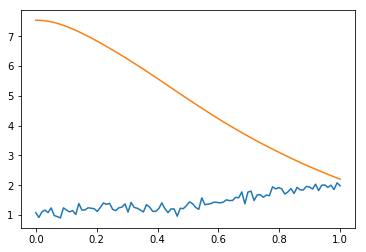

89/120 rows complete
Optimization restart 1/5, f = 9.114556096745112
Optimization restart 2/5, f = 7.253100157014934
Optimization restart 3/5, f = 7.253100157150911
Optimization restart 4/5, f = 107.05374360461344
Optimization restart 5/5, f = 7.212429134719208

Probability Sales Increasing is: 1.0
Sales Increasing: True


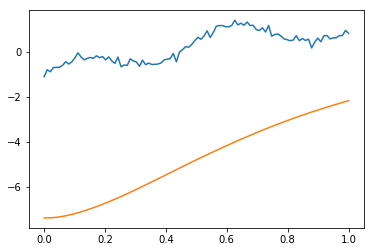

90/120 rows complete
Optimization restart 1/5, f = -94.24155519927335
Optimization restart 2/5, f = -95.09653889860883
Optimization restart 3/5, f = -93.76608726470371
Optimization restart 4/5, f = -96.17005032968916
Optimization restart 5/5, f = -94.47383768201628

Probability Sales Increasing is: 0.36
Sales Increasing: False


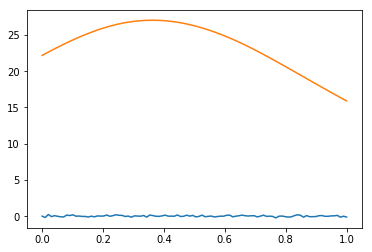

91/120 rows complete
Optimization restart 1/5, f = -85.50780212268188
Optimization restart 2/5, f = -83.92954041346505
Optimization restart 3/5, f = -82.36163183565654
Optimization restart 4/5, f = -82.36162849089494
Optimization restart 5/5, f = -85.8997640387221

Probability Sales Increasing is: 0.95
Sales Increasing: True


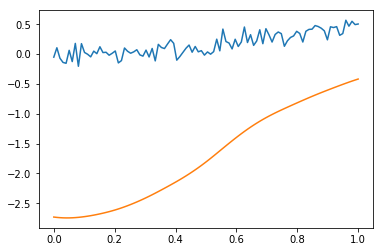

92/120 rows complete
Optimization restart 1/5, f = -78.97503553036873
Optimization restart 2/5, f = -75.88975848590118
Optimization restart 3/5, f = -76.99762593174505
Optimization restart 4/5, f = -77.33501719990274
Optimization restart 5/5, f = -76.80786892419873

Probability Sales Increasing is: 0.0
Sales Increasing: False


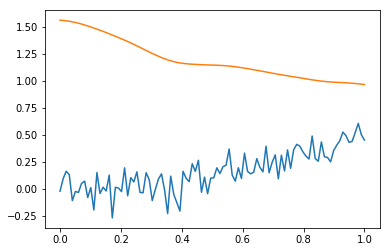

93/120 rows complete
Optimization restart 1/5, f = -99.57981914877931
Optimization restart 2/5, f = -97.95228266698163
Optimization restart 3/5, f = -98.98663061337936
Optimization restart 4/5, f = -98.97305596128655
Optimization restart 5/5, f = -98.7199667056851

Probability Sales Increasing is: 0.93
Sales Increasing: True


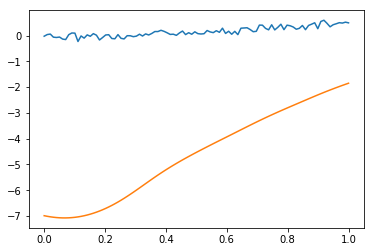

94/120 rows complete
Optimization restart 1/5, f = -81.38410484137893
Optimization restart 2/5, f = -79.51846036732647
Optimization restart 3/5, f = -80.68031759585642
Optimization restart 4/5, f = -80.68031437482306
Optimization restart 5/5, f = -73.582596565002

Probability Sales Increasing is: 0.65
Sales Increasing: False


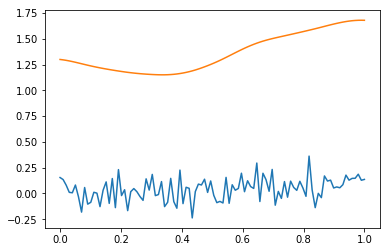

95/120 rows complete
Optimization restart 1/5, f = -74.91782761693065
Optimization restart 2/5, f = -74.2277722142257
Optimization restart 3/5, f = -73.78830644688527
Optimization restart 4/5, f = -73.46868651681812
Optimization restart 5/5, f = -74.22370973767755

Probability Sales Increasing is: 0.78
Sales Increasing: False


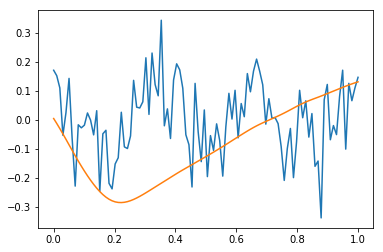

96/120 rows complete
Optimization restart 1/5, f = -38.731819431044514
Optimization restart 2/5, f = -33.78194144409661
Optimization restart 3/5, f = -14.620266565650361
Optimization restart 4/5, f = -30.8263451534132
Optimization restart 5/5, f = -14.620270211257669

Probability Sales Increasing is: 1.0
Sales Increasing: True


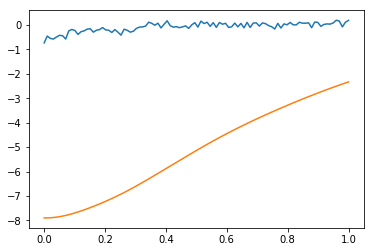

97/120 rows complete
Optimization restart 1/5, f = -72.76474086027213
Optimization restart 2/5, f = -72.40032751814027
Optimization restart 3/5, f = -72.59307933898955
Optimization restart 4/5, f = -72.61157948162894
Optimization restart 5/5, f = -72.64402231352132

Probability Sales Increasing is: 0.57
Sales Increasing: False


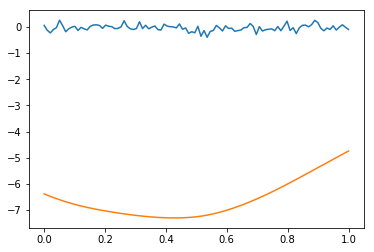

98/120 rows complete
Optimization restart 1/5, f = -92.71809345750471
Optimization restart 2/5, f = -90.95159630823066
Optimization restart 3/5, f = -90.57329265001539
Optimization restart 4/5, f = -92.40452280765669
Optimization restart 5/5, f = -92.60419512776303

Probability Sales Increasing is: 0.65
Sales Increasing: False


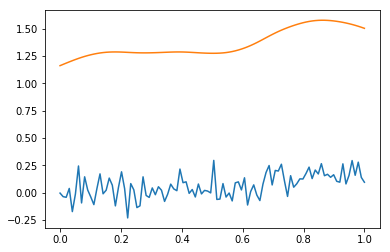

99/120 rows complete
Optimization restart 1/5, f = -84.8958313561587
Optimization restart 2/5, f = -83.40293696499863
Optimization restart 3/5, f = -84.50234669809056
Optimization restart 4/5, f = -83.38234113873426
Optimization restart 5/5, f = -83.84769062585454

Probability Sales Increasing is: 0.11
Sales Increasing: False


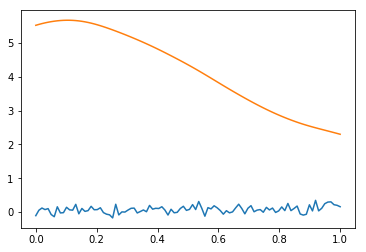

100/120 rows complete
Optimization restart 1/5, f = -59.206455105194266
Optimization restart 2/5, f = -62.184551042086255
Optimization restart 3/5, f = -62.184551061849916
Optimization restart 4/5, f = 69.97079685130389
Optimization restart 5/5, f = -62.179269848850836

Probability Sales Increasing is: 0.04
Sales Increasing: False


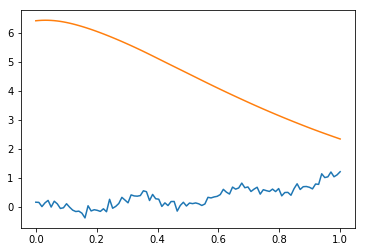

101/120 rows complete
Optimization restart 1/5, f = -68.85958592018554
Optimization restart 2/5, f = -69.66117842342072
Optimization restart 3/5, f = -68.68382852002982
Optimization restart 4/5, f = -67.07198379429428
Optimization restart 5/5, f = -68.10804487979914

Probability Sales Increasing is: 0.05
Sales Increasing: False


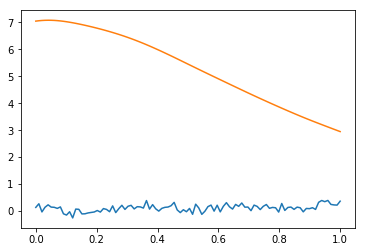

102/120 rows complete
Optimization restart 1/5, f = -1.40122944294788
Optimization restart 2/5, f = -3.3178625078808963
Optimization restart 3/5, f = -2.719689116085739
Optimization restart 4/5, f = -2.7196953048885533
Optimization restart 5/5, f = -3.3178625077170167

Probability Sales Increasing is: 0.99
Sales Increasing: True


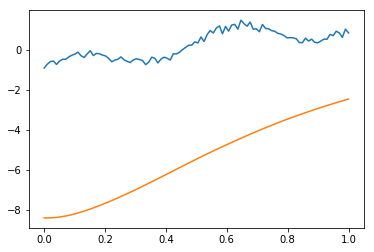

103/120 rows complete
Optimization restart 1/5, f = -78.9265000337029
Optimization restart 2/5, f = -76.5192008672439
Optimization restart 3/5, f = -78.80927505724637
Optimization restart 4/5, f = -78.10167180451367
Optimization restart 5/5, f = -78.80927405436798

Probability Sales Increasing is: 0.08
Sales Increasing: False


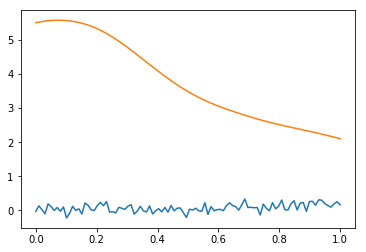

104/120 rows complete
Optimization restart 1/5, f = -75.85137396288047
Optimization restart 2/5, f = -76.21807913972265
Optimization restart 3/5, f = -75.84460611881569
Optimization restart 4/5, f = -75.851373955492
Optimization restart 5/5, f = -73.92972769014594

Probability Sales Increasing is: 0.97
Sales Increasing: True


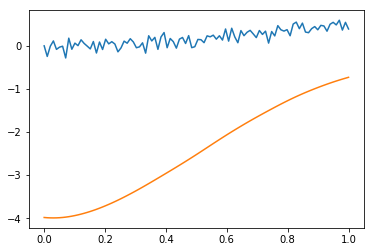

105/120 rows complete
Optimization restart 1/5, f = -85.3570843794831
Optimization restart 2/5, f = -85.26637115003027
Optimization restart 3/5, f = -85.36034860875428
Optimization restart 4/5, f = -85.34524595229735
Optimization restart 5/5, f = -81.53830393913046

Probability Sales Increasing is: 0.5
Sales Increasing: False


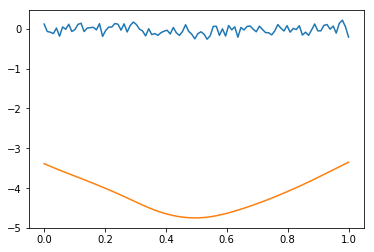

106/120 rows complete
Optimization restart 1/5, f = -0.40449854978371036
Optimization restart 2/5, f = 1.6223150798761736
Optimization restart 3/5, f = -0.40449854975736343
Optimization restart 4/5, f = 0.10236033555676016
Optimization restart 5/5, f = -0.404498549757939

Probability Sales Increasing is: 1.0
Sales Increasing: True


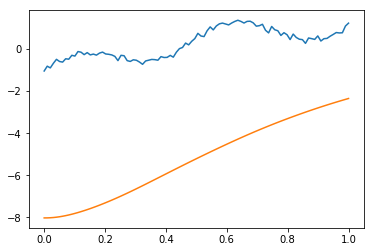

107/120 rows complete
Optimization restart 1/5, f = 8.206447636178105
Optimization restart 2/5, f = 8.206447635958185
Optimization restart 3/5, f = 7.89673260448771
Optimization restart 4/5, f = 8.231589478008097
Optimization restart 5/5, f = 7.897735994870061

Probability Sales Increasing is: 0.0
Sales Increasing: False


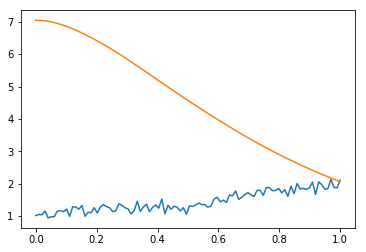

108/120 rows complete
Optimization restart 1/5, f = -80.65064027958911
Optimization restart 2/5, f = -76.6031919310687
Optimization restart 3/5, f = -80.629192482131
Optimization restart 4/5, f = -80.48464033430702
Optimization restart 5/5, f = -75.60261818067414

Probability Sales Increasing is: 0.44
Sales Increasing: False


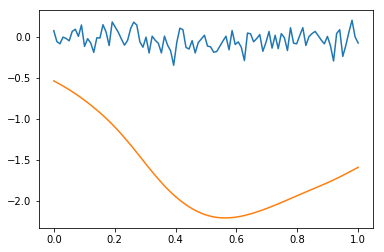

109/120 rows complete
Optimization restart 1/5, f = -64.10298722974824
Optimization restart 2/5, f = -10.074279112419575
Optimization restart 3/5, f = -66.41205656005081
Optimization restart 4/5, f = -70.06400759646897
Optimization restart 5/5, f = -64.18434643256626

Probability Sales Increasing is: 0.01
Sales Increasing: False


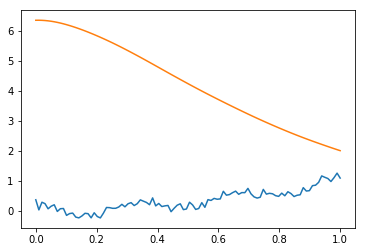

110/120 rows complete
Optimization restart 1/5, f = -2.040493058258285
Optimization restart 2/5, f = -2.0400064934399396
Optimization restart 3/5, f = 184.08475240542936
Optimization restart 4/5, f = -2.0400065018135933
Optimization restart 5/5, f = 127.0224704862324

Probability Sales Increasing is: 0.0
Sales Increasing: False


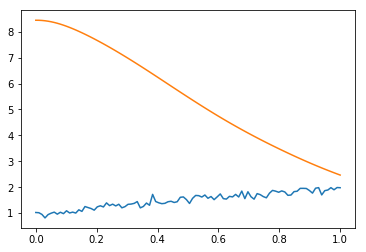

111/120 rows complete
Optimization restart 1/5, f = 3.0939360869097143
Optimization restart 2/5, f = 3.093936085951583
Optimization restart 3/5, f = 51.9492199741181
Optimization restart 4/5, f = 3.093936086346332
Optimization restart 5/5, f = 3.0939360860118086

Probability Sales Increasing is: 0.0
Sales Increasing: False


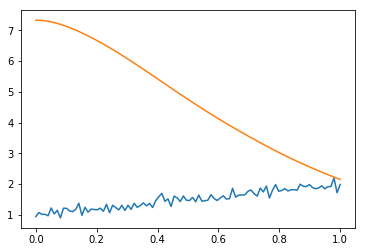

112/120 rows complete
Optimization restart 1/5, f = -1.8977095106261785
Optimization restart 2/5, f = -1.907826481791922
Optimization restart 3/5, f = -2.8198354744527023
Optimization restart 4/5, f = -10.28775315074568
Optimization restart 5/5, f = -11.722764462273041

Probability Sales Increasing is: 1.0
Sales Increasing: True


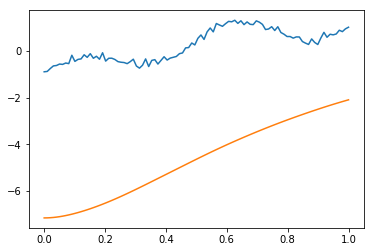

113/120 rows complete
Optimization restart 1/5, f = 7.09672483788755
Optimization restart 2/5, f = 178.34998158865363
Optimization restart 3/5, f = 5.42989377526672
Optimization restart 4/5, f = 6.980655041261144
Optimization restart 5/5, f = -7.677494776754521

Probability Sales Increasing is: 0.0
Sales Increasing: False


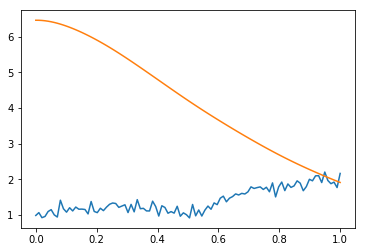

114/120 rows complete
Optimization restart 1/5, f = 5.654532907103103
Optimization restart 2/5, f = 20.18217808767352
Optimization restart 3/5, f = 5.644092781752079
Optimization restart 4/5, f = 5.444709958794199
Optimization restart 5/5, f = 180.52244724366489

Probability Sales Increasing is: 0.0
Sales Increasing: False


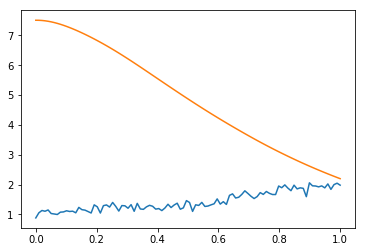

115/120 rows complete
Optimization restart 1/5, f = -88.04180361914638
Optimization restart 2/5, f = -87.26974440440515
Optimization restart 3/5, f = -86.42754126220217
Optimization restart 4/5, f = -87.26973008167181
Optimization restart 5/5, f = -86.42753800541104

Probability Sales Increasing is: 1.0
Sales Increasing: True


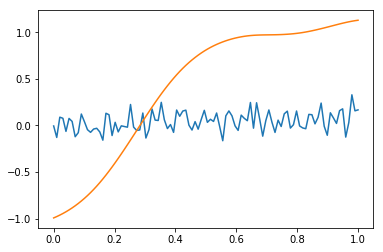

116/120 rows complete
Optimization restart 1/5, f = -2.1496094461419872
Optimization restart 2/5, f = 20.046986080358643
Optimization restart 3/5, f = -1.9748054593866726
Optimization restart 4/5, f = -3.040975251998809
Optimization restart 5/5, f = 79.63851166216692

Probability Sales Increasing is: 0.0
Sales Increasing: False


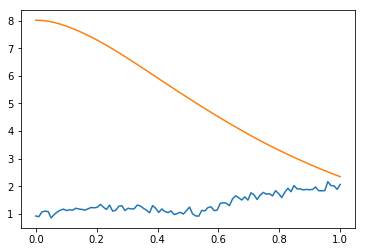

117/120 rows complete
Optimization restart 1/5, f = 3.8556303713732945
Optimization restart 2/5, f = 3.7691753129590353
Optimization restart 3/5, f = 50.296066043378985
Optimization restart 4/5, f = 4.319966289457497
Optimization restart 5/5, f = 3.855630371242114

Probability Sales Increasing is: 0.0
Sales Increasing: False


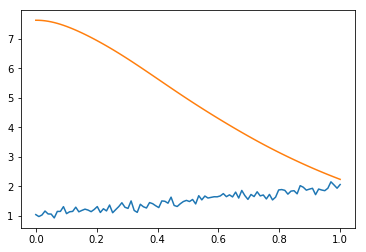

118/120 rows complete
Optimization restart 1/5, f = -36.860170918563675
Optimization restart 2/5, f = -32.351063668485786
Optimization restart 3/5, f = -17.508228454423552
Optimization restart 4/5, f = -17.50822554472034
Optimization restart 5/5, f = -17.508227159528147

Probability Sales Increasing is: 0.99
Sales Increasing: True


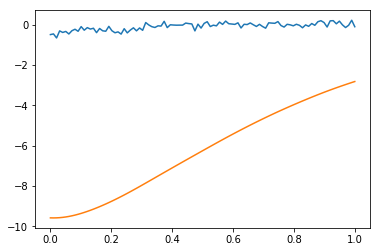

119/120 rows complete
Optimization restart 1/5, f = 11.70779317841314
Optimization restart 2/5, f = 11.935951633361917
Optimization restart 3/5, f = 11.7077931672165
Optimization restart 4/5, f = 30.6747562630622
Optimization restart 5/5, f = 70.86555326109296

Probability Sales Increasing is: 0.0
Sales Increasing: False


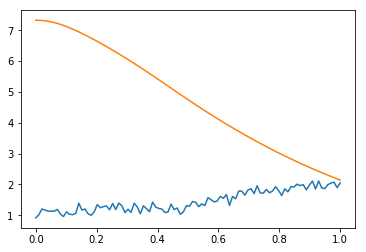

120/120 rows complete
      Id Category
0      0        0
1      1        1
2      2        0
3      3        0
4      4        0
5      5        0
6      6        0
7      7        1
8      8        0
9      9        1
10    10        0
11    11        1
12    12        0
13    13        0
14    14        0
15    15        1
16    16        1
17    17        0
18    18        1
19    19        1
20    20        1
21    21        0
22    22        0
23    23        0
24    24        0
25    25        0
26    26        0
27    27        1
28    28        0
29    29        0
..   ...      ...
90    90        0
91    91        1
92    92        0
93    93        1
94    94        0
95    95        0
96    96        1
97    97        0
98    98        0
99    99        0
100  100        0
101  101        0
102  102        1
103  103        0
104  104        1
105  105        0
106  106        1
107  107        0
108  108        0
109  109        0
110  110        0
111  111        0
112  1

In [26]:
Decision = make_decision(test_df, run_model_gpy)
Decision.to_csv('submission_gpy.csv')

print(Decision)